# Recommender System

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from collections import Counter, defaultdict
from operator import itemgetter
import tensorflow as tf
from tensorflow import keras
from pylab import rcParams
from pylab import savefig
import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import recall_at_k
from lightfm.cross_validation import random_train_test_split
from scipy.sparse import csr_matrix
import scipy
import recmetrics

from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score
import matplotlib.ticker as ticker
from math import sqrt
from sklearn.metrics import mean_squared_error

C:\Users\user\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [3]:
# Install Altair and activate its colab renderer.
#print("Installing Altair...")
#!pip install git+git://github.com/altair-viz/altair.git
#import altair as alt
#alt.data_transformers.enable('default', max_rows=None)
#alt.renderers.enable('colab')
#print("Done installing Altair.")

# Install spreadsheets and import authentication module.
#USER_RATINGS = False
#!pip install --upgrade -q gspread
#from google.colab import auth
#import gspread
#from oauth2client.client import GoogleCredentials

In [4]:
import matplotlib.pyplot as plt
import os
import warnings
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

Firstly, I converted my data files from .dat to .csv format. I did this via excel using the data tab and it's "get external data" option and extracted it from text. All the delimiting was done by default and I had my files in a delimited format.

##### To start I read in all of my files and fixed the index for user ID's and artist ID's. This would save us a lot of problems later on when we try to join these dataframes together so doing it initially made the most sense.

In [5]:
df = pd.read_csv("data/hetrec2011-lastfm-2k/artists.csv")
df

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...
...,...,...,...,...
17627,18741,Diamanda GalÃ¡s,http://www.last.fm/music/Diamanda+Gal%C3%A1s,http://userserve-ak.last.fm/serve/252/16352971...
17628,18742,Aya RL,http://www.last.fm/music/Aya+RL,http://userserve-ak.last.fm/serve/252/207445.jpg
17629,18743,Coptic Rain,http://www.last.fm/music/Coptic+Rain,http://userserve-ak.last.fm/serve/252/344868.jpg
17630,18744,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,http://userserve-ak.last.fm/serve/252/29297695...


In [6]:
df['id'] = pd.to_numeric(df['id'])
lst = []
m = np.array(df['id'])
for i in range(0,17632):
    #print(i)
    if i not in df.id.values:
        lst.append(i)

len(lst)

965

Just taking a quick look at the data I could see the last few artist ID's were 18743... and I later found out this would prove problematic. This for loop above demonstrates that in the range of 0 to 17632 (the number of unique artist ID's as per our readME) that there are 965 missing values for this range. This is something we will rectify in all our files.

In [7]:
newart = []
for i in range(0, 17632):
    newart.append(i)

In [8]:
newart = np.array(newart)
df['artID'] = newart.tolist()

In [9]:
df.drop(columns=['id'], inplace=True)
df.head()

,name,url,pictureURL,artID
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg,0
1,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg,1
2,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...,2
3,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...,3
4,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...,4


Our artist ID's are fixed for this file now. There appears to be some unclean names such as "Diamanda GalÃ¡s" among others just taking an initial look at the data here.

#### Faulty ID values in one file!
I had to alter my approach slightly hence why df4 is read in secondly. I found in this dataframe that there were users that did not appear in other dataframes so I had to remove these users from this dataframe and reindex accordingly. I noticed this due to some very strange tags associated with "AC/DC" which we will see later and have been fixed now. All the rough work related to this can be found in another file "recommender-past.ipynb" on the github repository for this assignment.

In [10]:
df4 = pd.read_csv("data/hetrec2011-lastfm-2k/user_taggedartists-timestamps.csv")
df4

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009
...,...,...,...,...,...,...
186474,2100,16437,4,1,7,2010
186475,2100,16437,292,1,5,2010
186476,2100,16437,2087,1,7,2010
186477,2100,16437,2801,1,5,2010


In [11]:
vals = (df4['artistID'].unique()).tolist()
vals.sort()
values = []
for i in range(len(vals)):
    if vals[i] in m:
        values.append(vals[i])

In [12]:
missing = []
for i in range(len(vals)):
    if vals[i] not in values:
        missing.append(vals[i])

In [13]:
list3 = values + missing
print(len(list3))

12523


In [14]:
df4 = df4[~df4.artistID.isin(missing)]

In [250]:
# from earlier
keys = m
values = newart
dictionary = dict(zip(keys, values))
#print(dictionary) # {'a': 1, 'b': 2, 'c': 3}

In [16]:
a_subset = {key: value for key, value in dictionary.items() if key in list3}

In [17]:
s = df4['artistID']

df4['artistID'] = s.map(a_subset)

C:\Users\user\AppData\Local\Temp/ipykernel_28620/3743877304.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['artistID'] = s.map(a_subset)


In [18]:
df1 = pd.read_csv("data/hetrec2011-lastfm-2k/tags.csv")
df1

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal
...,...,...
11941,12644,suomi
11942,12645,symbiosis
11943,12646,sverige
11944,12647,eire


This file is exclusively dealing with tags. We can disregard changing the index for now.

In [19]:
df2 = pd.read_csv("data/hetrec2011-lastfm-2k/user_artists.csv")
df2

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983
...,...,...,...
92829,2100,18726,337
92830,2100,18727,297
92831,2100,18728,281
92832,2100,18729,280


Due to the fact values are repeated here we can't simply do what we did before to fix the ID values. We also have the presence of userID's which has a similar index problem. We will implement a dictionary to fix these values and map the old values to our new values.

In [20]:
df2['artistID'].min()

1

In [21]:
# Since the ids start at 2, we get them to start at 0. We also need to have the max value 1 less than the no of unique values.
df2["userID"] = df2["userID"].apply(lambda x: str(x-2))
df2["artistID"] = df2["artistID"].apply(lambda x: str(x-1))

In [22]:
df2['userID'] = df2['userID'].astype(int)
xyz =  np.array(df2['userID'])
#zzz = np.array(played['userID'])
vals = []
for i in range(len(xyz)):
    v = xyz[i]
    if v not in vals:
        vals.append(v)
    else:
        continue

In [23]:
vals[-1]

2098

In [24]:
unique_list = list(set(vals))
unique_list.sort()
unique_list[-1]

2098

In [25]:
usenew = []
for i in range(0, 1892):
    usenew.append(i)

usenew[-1]

1891

In [26]:
keys = unique_list
values = usenew
dictionary = dict(zip(keys, values))
#print(dictionary) # {'a': 1, 'b': 2, 'c': 3}

In [27]:
s = df2['userID']

df2['userID'] = s.map(dictionary)

In [28]:
df2.head()

,userID,artistID,weight
0,0,50,13883
1,0,51,11690
2,0,52,11351
3,0,53,10300
4,0,54,8983


In [29]:
df2['artistID'] = df2['artistID'].astype(int)
xyz =  np.array(df2['artistID'])
#zzz = np.array(played['userID'])
vals = []
for i in range(len(xyz)):
    v = xyz[i]
    if v not in vals:
        vals.append(v)
    else:
        continue

In [30]:
unique_list = list(set(vals))
unique_list.sort()
unique_list[0]

0

In [31]:
usenew = []
for i in range(0, 17632):
    usenew.append(i)

usenew[-1]

17631

In [32]:
keys = unique_list
values = usenew
diction = dict(zip(keys, values))
#print(diction) # {'a': 1, 'b': 2, 'c': 3}

In [33]:
s = df2['artistID']

df2['artistID'] = s.map(diction)

In [34]:
df2['weight'].max()

352698

In [35]:
df2

,userID,artistID,weight
0,0,45,13883
1,0,46,11690
2,0,47,11351
3,0,48,10300
4,0,49,8983
...,...,...,...
92829,1891,17615,337
92830,1891,17616,297
92831,1891,17617,281
92832,1891,17618,280


Our dataframe "df2" is now adjusted correctly.

In [36]:
df3 = pd.read_csv("data/hetrec2011-lastfm-2k/user_friends.csv")
df3

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831
...,...,...
25429,2099,1801
25430,2099,2006
25431,2099,2016
25432,2100,586


In [37]:
# Since the ids start at 2, we get them to start at 0. We also need to have the max value 1 less than the no of unique values.
df3["userID"] = df3["userID"].apply(lambda x: str(x-2))
df3["friendID"] = df3["friendID"].apply(lambda x: str(x-2))

df3['userID'] = pd.to_numeric(df3['userID'])
df3['friendID'] = pd.to_numeric(df3['friendID'])

In [38]:
df3['friendID'].max()

2098

In [39]:
df3['friendID'].nunique()

1892

In [40]:
xyz =  np.array(df3['userID'])
#zzz = np.array(df2['userID'])
vals = []
for i in range(len(xyz)):
    if xyz[i] not in vals:
        vals.append(xyz[i])

In [41]:
unique_list = list(set(vals))
unique_list.sort()
unique_list[-1]

2098

In [42]:
usenew = []
for i in range(0, 1892):
    usenew.append(i)

usenew[-1]

1891

In [43]:
keys = unique_list
values = usenew
dictionary = dict(zip(keys, values))
#print(dictionary) # {'a': 1, 'b': 2, 'c': 3}

In [44]:
s = df3['userID']

df3['userID'] = s.map(dictionary)

In [45]:
o = df3['friendID']

df3['friendID'] = o.map(dictionary)

In [46]:
df3['friendID'].max()

1891

In [47]:
df3.isnull().values.any()

False

In [48]:
df4

,userID,artistID,tagID,day,month,year
0,2,46,13,1,4,2009
1,2,46,15,1,4,2009
2,2,46,18,1,4,2009
3,2,46,21,1,4,2009
4,2,46,41,1,4,2009
...,...,...,...,...,...,...
186474,2100,15609,4,1,7,2010
186475,2100,15609,292,1,5,2010
186476,2100,15609,2087,1,7,2010
186477,2100,15609,2801,1,5,2010


In [49]:
# Since the ids start at 2, we get them to start at 0. We also need to have the max value 1 less than the no of unique values.
df4["userID"] = df4["userID"].apply(lambda x: str(x-2))
df4['userID'] = df4['userID'].astype(int)

C:\Users\user\AppData\Local\Temp/ipykernel_28620/3309841126.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["userID"] = df4["userID"].apply(lambda x: str(x-2))
C:\Users\user\AppData\Local\Temp/ipykernel_28620/3309841126.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['userID'] = df4['userID'].astype(int)


In [50]:
s = df4['userID']

df4['userID'] = s.map(dictionary)
#print(dictionary)

C:\Users\user\AppData\Local\Temp/ipykernel_28620/432615126.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['userID'] = s.map(dictionary)


In [51]:
df4

,userID,artistID,tagID,day,month,year
0,0,46,13,1,4,2009
1,0,46,15,1,4,2009
2,0,46,18,1,4,2009
3,0,46,21,1,4,2009
4,0,46,41,1,4,2009
...,...,...,...,...,...,...
186474,1891,15609,4,1,7,2010
186475,1891,15609,292,1,5,2010
186476,1891,15609,2087,1,7,2010
186477,1891,15609,2801,1,5,2010


In [52]:
df4.drop(columns=['day', 'month', 'year'], inplace=True)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [53]:
tags = pd.merge(df1, df4, how="inner", left_on="tagID", right_on="tagID")
tags.isnull().values.any()
tags['artistID'].max()

17630

All of our dataframes have the correct index for artist ID's and user ID's now. This will help us avoid any errors with our recommender model now.

# Methodology
Now that all our data files are read in and in the appropriate format we will begin our end to end process. These are as follows:
##### 1. Data cleaning and processing
##### 2. Visualization of trends in the data
##### 3. Fitting our Model
##### 4. Evaluating our Model

# Cleaning and Processing

### Initial analysis and cleaning

In [54]:
df['name'].value_counts()

MALICE MIZER                        1
BEAT!BEAT!BEAT!                     1
ãƒˆã‚¯ãƒžãƒ«ã‚·ãƒ¥ãƒ¼ã‚´            1
Thao with The Get Down Stay Down    1
ãƒªã‚¢ãƒ»ãƒ‡ã‚£ã‚¾ãƒ³               1
                                   ..
Innerpartysystem                    1
Helia                               1
Devil Sold His Soul                 1
Nevea Tears                         1
Grzegorz Tomczak                    1
Name: name, Length: 17632, dtype: int64

##### Let's check all our dataframes for null values to start.

In [55]:
dfs = [df, df1, df2, df3, df4]
na = []
for i in range(len(dfs)):
    if dfs[i].isnull().values.any() > 0:
        na.append(dfs[i])

In [56]:
na

[                    name                                           url  \
 0           MALICE MIZER         http://www.last.fm/music/MALICE+MIZER   
 1        Diary of Dreams      http://www.last.fm/music/Diary+of+Dreams   
 2      Carpathian Forest    http://www.last.fm/music/Carpathian+Forest   
 3           Moi dix Mois         http://www.last.fm/music/Moi+dix+Mois   
 4            Bella Morte          http://www.last.fm/music/Bella+Morte   
 ...                  ...                                           ...   
 17627    Diamanda GalÃ¡s  http://www.last.fm/music/Diamanda+Gal%C3%A1s   
 17628             Aya RL               http://www.last.fm/music/Aya+RL   
 17629        Coptic Rain          http://www.last.fm/music/Coptic+Rain   
 17630       Oz Alchemist         http://www.last.fm/music/Oz+Alchemist   
 17631   Grzegorz Tomczak     http://www.last.fm/music/Grzegorz+Tomczak   
 
                                               pictureURL  artID  
 0        http://userserve-ak.l

The only dataframe with nulls is our artists dataframe. Let's investigate this further to see if there is any important missing values such as ID's etc.

In [57]:
df.dtypes

name          object
url           object
pictureURL    object
artID          int64
dtype: object

In [58]:
features_with_na = [features for features in df.columns if df[features].isnull().sum() > 0]

for feature in features_with_na: 
    print(feature, np.round(df[feature].isnull().mean(), 4), '% missing values')
    print(features_with_na)

pictureURL 0.0252 % missing values
['pictureURL']


This is a positive result as there are very few null values in the dataframe and the small amount that exist are in a column of lesser important that we will not need to impute missing values for.

In [59]:
played = pd.merge(df, df2, how="inner", left_on="artID", right_on="artistID")
played.rename(columns={"weight": "played"}, inplace=True)

We will drop the pictureURL column as there is not much information to be gained and there is some nulls present.

In [60]:
played.drop(columns=['pictureURL'], inplace=True)

## Analysis and Visualization

In [61]:
mean = played['played'].mean()
print("The mean number of times a user plays a song is: " + str(mean))

The mean number of times a user plays a song is: 745.2439300256372


In [62]:
median = played['played'].median()
print("The median number of times a user plays a song is: " + str(median))

The median number of times a user plays a song is: 260.0


<AxesSubplot:>

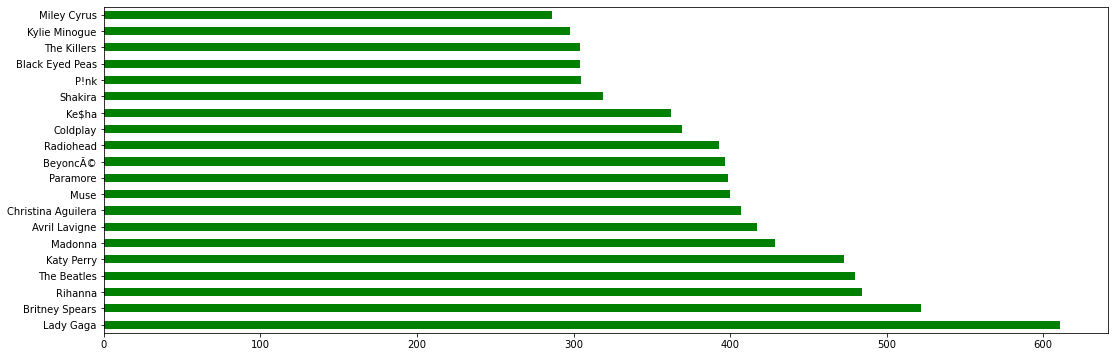

In [63]:
played['name'].value_counts()[:20].plot(kind='barh', color='green', figsize=(18,6))

Lady Gaga is by a long distance the most popular artist going by the number of unqiue users listening to her, with approximately 100 more users listening to her in contrast to our second ranked artist.

[Text(0.5, 1.0, 'Box plot of played values for users')]

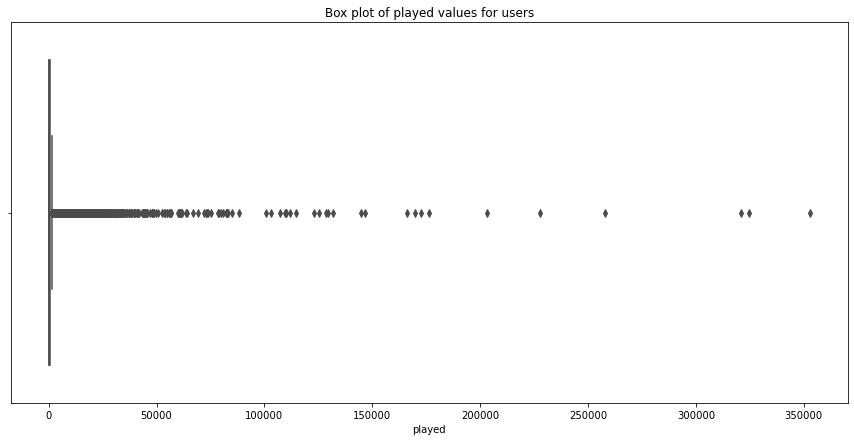

In [64]:
plt.figure(figsize=[15,7])
sns.boxplot(x=played['played'], color="gold").set(title='Box plot of played values for users')

There appears to be quite a lot of outliers here in the played column. Some users have obviously played their artists songs far more times than the average. We double check our values for mean and median earlier and can confirm there are quite a few outliers here.

In [65]:
played.describe()

,artID,userID,artistID,played
count,92834.000000,92834.000000,92834.000000,92834.00000
mean,3235.736724,944.222483,3235.736724,745.24393
std,4197.216910,546.751074,4197.216910,3751.32208
min,0.000000,0.000000,0.000000,1.00000
25%,430.000000,470.000000,430.000000,107.00000
50%,1237.000000,944.000000,1237.000000,260.00000
75%,4266.000000,1416.000000,4266.000000,614.00000
max,17631.000000,1891.000000,17631.000000,352698.00000


Let's now plot some information regarding our artists.

In [66]:
grouped_multiple = played.groupby(['artistID', 'name']).agg({'played': ['mean', 'median', 'max', 'sum']})
grouped_multiple.columns = ['mean', 'med', 'max', 'sum']
grouped_multiple = grouped_multiple.reset_index()
#grouped_multiple.sort('price_mean', ascending=False)
grouped_multiple = pd.DataFrame(grouped_multiple)

In [67]:
artdf = grouped_multiple.sort_values(by=['sum'], ascending=False)

In [68]:
artdf

,artistID,name,mean,med,max,sum
283,283,Britney Spears,4584.559387,1000.5,131733,2393140
66,66,Depeche Mode,4614.567376,567.0,352698,1301308
83,83,Lady Gaga,2113.563011,590.0,114672,1291387
286,286,Christina Aguilera,2600.503686,739.0,176133,1058405
492,492,Paramore,2414.659148,417.0,227829,963449
...,...,...,...,...,...,...
16522,16522,K-Precise,1.000000,1.0,1,1
13713,13713,ZÃœNDER,1.000000,1.0,1,1
13712,13712,Evil Masquerade,1.000000,1.0,1,1
16239,16239,Gosling,1.000000,1.0,1,1


In [69]:
pt2 = artdf.head(20)

<AxesSubplot:title={'center':'Biggest artists by no of listens'}, xlabel='Artist', ylabel='Songs played'>

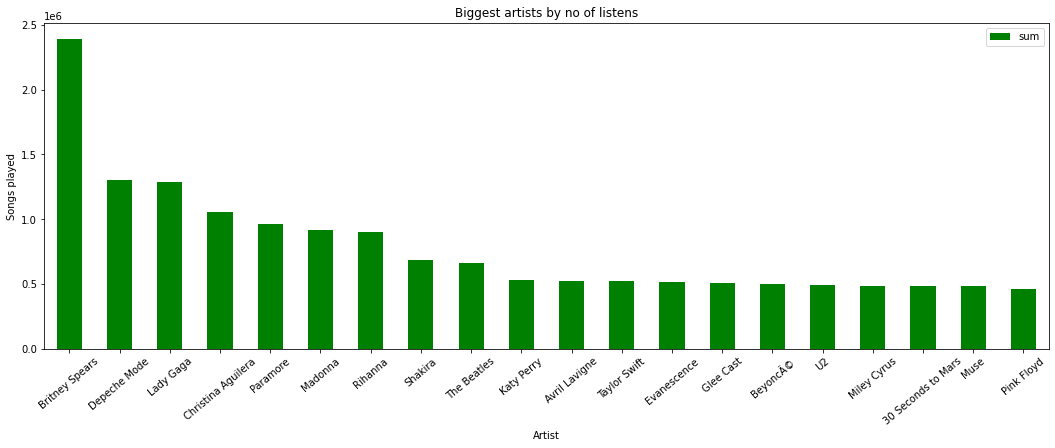

In [70]:
pt2.plot.bar(x = 'name', y = 'sum', rot = 40, figsize=(18, 6), color='green', xlabel='Artist', ylabel='Songs played', title='Biggest artists by no of listens')

Despite Lady Gaga having the clear higher number of unique users listening to her she is only third in the most played artist by a distance with Britney Spears having the most amount of times her songs were played. This graph appears to suggest that this dataset is heavily leaned towards the most popular artists. From 'Shakira' on there appears to be a consistent base of artists with 500,000 or more plays. We will look at the same plot for users now before we come back to this.

In [71]:
grouped_multiple = played.groupby(['userID']).agg({'played': ['mean', 'median', 'max', 'sum']})
grouped_multiple.columns = ['mean', 'med', 'max', 'sum']
grouped_multiple = grouped_multiple.reset_index()
#grouped_multiple.sort('price_mean', ascending=False)
grouped_multiple = pd.DataFrame(grouped_multiple)

In [72]:
userdf = grouped_multiple.sort_values(by=['sum'], ascending=False)

In [73]:
pt3 = userdf.head(20)

<AxesSubplot:title={'center':'Users by highest number of plays'}, xlabel='User', ylabel='Listens'>

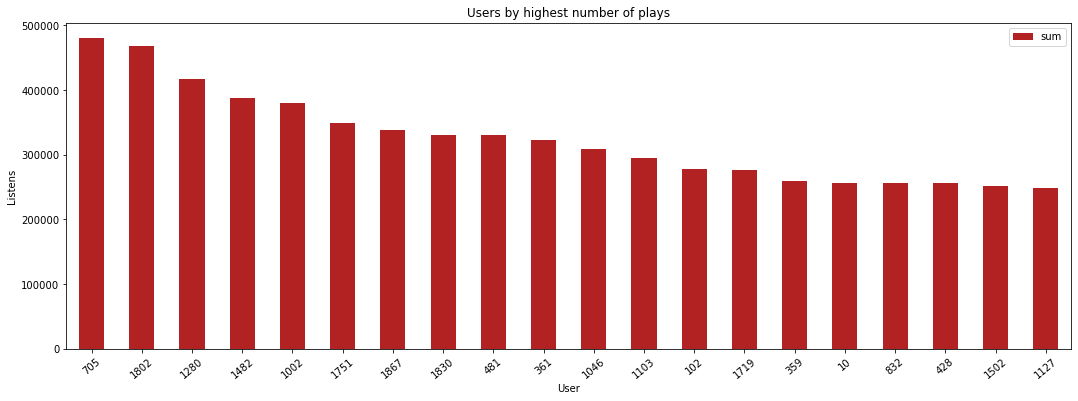

In [74]:
pt3.plot.bar(x = 'userID', y = 'sum', rot = 40, figsize=(18, 6), color='firebrick', xlabel='User', ylabel='Listens', title='Users by highest number of plays')

Comparing users to artists there doesn't seem to be an as obvious presence of outliers here. The two users with the highest 'played' values are noticeably ahead of rest but not to the extent as with artists. Due to there being a much smaller cohort of users to artists (1892 to 17632 respectively) it is fair to say that users may have a more even distribution with regards to songs played.

In [75]:
artdf['mean']

283      4584.559387
66       4614.567376
83       2113.563011
286      2600.503686
492      2414.659148
            ...     
16522       1.000000
13713       1.000000
13712       1.000000
16239       1.000000
16241       1.000000
Name: mean, Length: 17632, dtype: float64

In [76]:
played.shape

(92834, 6)

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

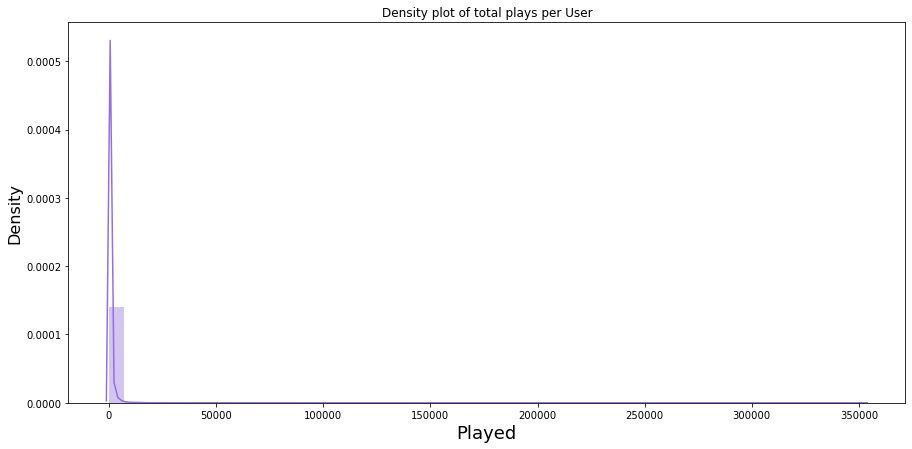

In [77]:
plt.figure(figsize=[15,7])
sns.distplot(played['played'], color="mediumpurple").set(title='Density plot of total plays per User')
plt.xlabel('Played', fontsize=18)
plt.ylabel('Density', fontsize=16)

The majority of values seem around the 1k or less mark. There are a lot of outlier values however going as far as 350,000 for the most extreme values. This confirms our earlier boxplot looking at these values in a clear manner.

In [78]:
xyz = pd.DataFrame(played['name'].value_counts())

In [79]:
xyz = xyz.reset_index()

In [80]:
xyz.rename(columns={'index': 'name', 'name': 'unique'}, inplace=True)

In [81]:
xyz

,name,unique
0,Lady Gaga,611
1,Britney Spears,522
2,Rihanna,484
3,The Beatles,480
4,Katy Perry,473
...,...,...
17627,Karmina,1
17628,Alexandre Desplat & Aaron Zigman,1
17629,Burning Brides,1
17630,ozzy,1


In [82]:
merged_df = artdf.merge(xyz, how = 'inner', on = ['name', 'name'])

In [83]:
merged_df

,artistID,name,mean,med,max,sum,unique
0,283,Britney Spears,4584.559387,1000.5,131733,2393140,522
1,66,Depeche Mode,4614.567376,567.0,352698,1301308,282
2,83,Lady Gaga,2113.563011,590.0,114672,1291387,611
3,286,Christina Aguilera,2600.503686,739.0,176133,1058405,407
4,492,Paramore,2414.659148,417.0,227829,963449,399
...,...,...,...,...,...,...,...
17627,16522,K-Precise,1.000000,1.0,1,1,1
17628,13713,ZÃœNDER,1.000000,1.0,1,1,1
17629,13712,Evil Masquerade,1.000000,1.0,1,1,1
17630,16239,Gosling,1.000000,1.0,1,1,1


In [84]:
percent = []
val = merged_df['unique']
total = played['userID'].nunique()
percent = []
for i in range(len(val)):
    y = val[i] / total
    percent.append(y)
    #print(y)

In [85]:
percent = np.array(percent)
artdf['Percentage'] = percent.tolist()

In [86]:
artdf

,artistID,name,mean,med,max,sum,Percentage
283,283,Britney Spears,4584.559387,1000.5,131733,2393140,0.275899
66,66,Depeche Mode,4614.567376,567.0,352698,1301308,0.149049
83,83,Lady Gaga,2113.563011,590.0,114672,1291387,0.322939
286,286,Christina Aguilera,2600.503686,739.0,176133,1058405,0.215116
492,492,Paramore,2414.659148,417.0,227829,963449,0.210888
...,...,...,...,...,...,...,...
16522,16522,K-Precise,1.000000,1.0,1,1,0.000529
13713,13713,ZÃœNDER,1.000000,1.0,1,1,0.000529
13712,13712,Evil Masquerade,1.000000,1.0,1,1,0.000529
16239,16239,Gosling,1.000000,1.0,1,1,0.000529


In [87]:
artdf['unique'] = merged_df['unique'].values

In [88]:
artdf

,artistID,name,mean,med,max,sum,Percentage,unique
283,283,Britney Spears,4584.559387,1000.5,131733,2393140,0.275899,522
66,66,Depeche Mode,4614.567376,567.0,352698,1301308,0.149049,282
83,83,Lady Gaga,2113.563011,590.0,114672,1291387,0.322939,611
286,286,Christina Aguilera,2600.503686,739.0,176133,1058405,0.215116,407
492,492,Paramore,2414.659148,417.0,227829,963449,0.210888,399
...,...,...,...,...,...,...,...,...
16522,16522,K-Precise,1.000000,1.0,1,1,0.000529,1
13713,13713,ZÃœNDER,1.000000,1.0,1,1,0.000529,1
13712,13712,Evil Masquerade,1.000000,1.0,1,1,0.000529,1
16239,16239,Gosling,1.000000,1.0,1,1,0.000529,1


In [89]:
artdf['Percentage'] = artdf['Percentage'].multiply(100)

In [90]:
artdf = artdf.sort_values(by=['Percentage'], ascending=False)

<AxesSubplot:title={'center':'Percentage of users who listen to most popular artists'}, xlabel='Artist', ylabel='% of unique users who listen'>

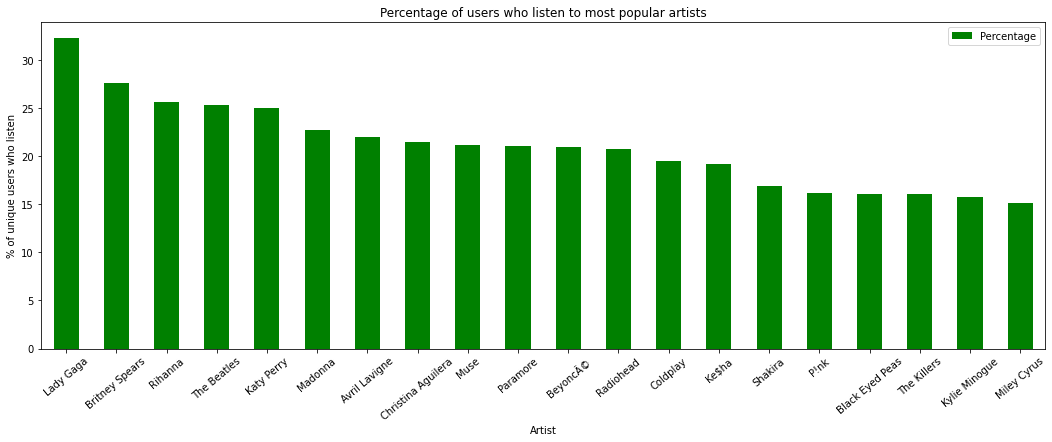

In [91]:
pt2 = artdf.head(20)
pt2.plot.bar(x = 'name', y = 'Percentage', rot = 40, figsize=(18, 6), color='green', xlabel='Artist', ylabel='% of unique users who listen', title='Percentage of users who listen to most popular artists')

This further seems to confirm our data is more geared towards the top. With such high percentages in relative terms of unique users listening to these artists it may cause issues such as the "cold-start" problem for our recommender. By this I mean with so many popular artists with such a high percent of users (and what appears to be fairly similar artists/genres) the recommender may struggle to recommend new or unknown artists to users. This is certainly the problem we seek to avoid. Let's check this information further below checking how many artists have between 1% and 5% of the total users listening to them. 

In [92]:
values = [1, 2, 3, 4, 5]
for i in range(len(values)):
    x = len(artdf[artdf['Percentage'] <= values[i]])
    print("The percentage of artists with " + str(values[i]) + "% or less users listening to them is " + str(x) + ".")

The percentage of artists with 1% or less users listening to them is 16794.
The percentage of artists with 2% or less users listening to them is 17200.
The percentage of artists with 3% or less users listening to them is 17350.
The percentage of artists with 4% or less users listening to them is 17430.
The percentage of artists with 5% or less users listening to them is 17497.


We can tell on the whole of the 17632 artists that there are actually very few who are listened to by a wide audience. There are less than 1000 artists who have more than 1% of users listening to them. This confirms our data is probably leaned very heavily towards the most popular artists such as Britney Spears or Lady Gaga as per our barchart above. Our below density plot confirms this.

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

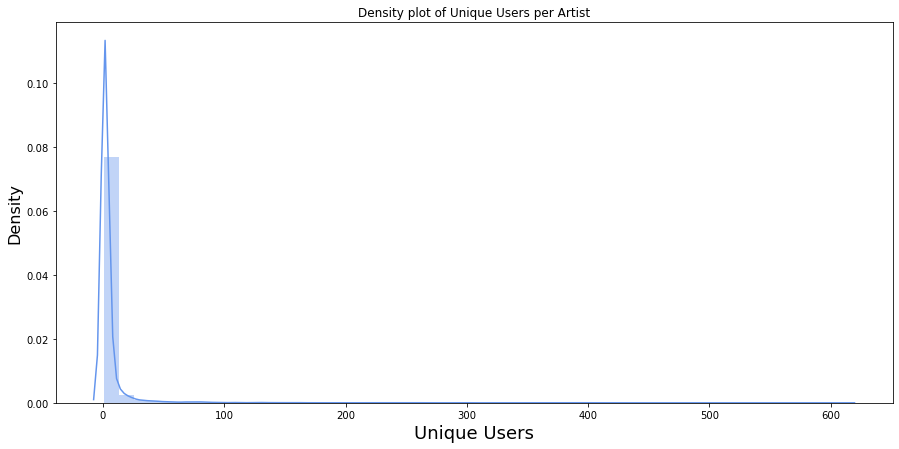

In [93]:
plt.figure(figsize=[15,7])
sns.distplot(artdf['unique'], color="cornflowerblue").set(title='Density plot of Unique Users per Artist')
plt.xlabel('Unique Users', fontsize=18)
plt.ylabel('Density', fontsize=16)

<AxesSubplot:>

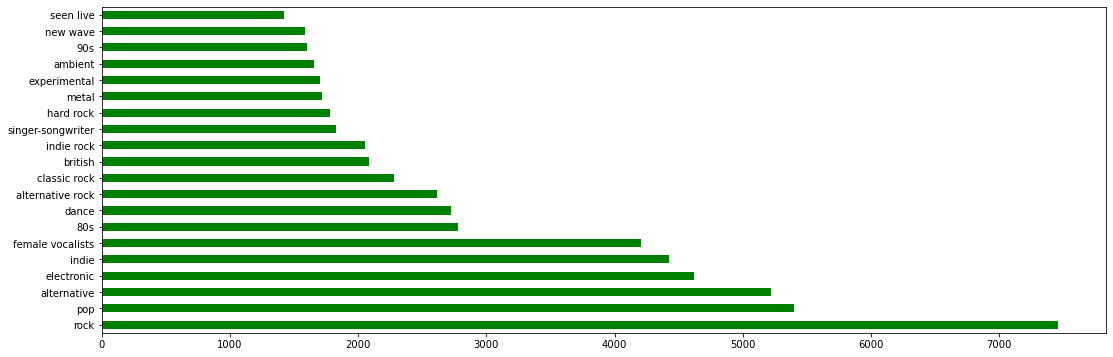

In [94]:
# Let's check most popular tags
tags['tagValue'].value_counts()[:20].plot(kind='barh', color='green', figsize=(18,6))

# Sparse Representation of Played matrix

In [95]:
# Calculate sparsity of matrix
def calculate_sparsity(M):
    matrix_size = float(M.shape[0] * M.shape[1]) # Number of total possible interactions between artist and user in the matrix
    num_plays = len(M.nonzero()[1]) # Number of times any artist has been interacted with
    sparsity = 100 * (1 - float(num_plays / matrix_size))
    return sparsity

## Normalising our played column
Next, one of the crucial aspects of our recommender system would be dealing with our played column. With such a diverse number of values from the range of 0 to over 350,000 we would have to deal with these appropriately. Our system would not be able to handle values of such a high nature and when I tried to run this I would get very high train errors and "nan" values for test error. I looked at a variety of different ways to normalize this value as a result and I would only incorporate two of these into my dataframe. I looked at capping any values above the 2,000 mark in our played column at 2,000 but errors persisted with this approach. As a result the methods I looked at were:

##### 1) Simple Normalization - normalizing all values based off the highest value in the "played" column.

##### 2) User based Normalization - grouping our played column by users and normalizing each user based off their own max value. I implemented this as a column called "playedUserNorm". This had the best results and was the column I implemented below.

##### 3) Play Count Scaled - here I would take each value in the column and take it away from the minimum value in the column. I would then divide this by the max value of the column minus the minimum value. I implemented this with the column "playCountScaled".

##### 4) Robust Scaling method - here we would scale each feature of the data set by subtracting the median and then dividing by the interquartile range. I tried this method but the results were poor and implementing it took a long time to run.


In [96]:
sm = played['played'].groupby(played['userID']).max()
artss = np.array(played['userID'])
playzz = np.array(played['played'])
#artss[-1]
newnorm = []
for i in range(len(playzz)):
    index = artss[i]
    val = playzz[i] / sm[index]
    newnorm.append(val)

In [97]:
newnorm = np.array(newnorm)

#add newnorm array as new column in DataFrame
played['playedUserNorm'] = newnorm.tolist()

In [98]:
played['playedUserNorm'].max()

1.0

In [99]:
pc = played.played
play_count_scaled = (pc - pc.min()) / (pc.max() - pc.min())

played = played.assign(playCountScaled=play_count_scaled)

In [100]:
# !!! here is our 1) simple normalisation

# played["playBasicNorm"] = played["played"] / played["played"].max()

In [101]:
# played['playCountScaled'].equals(played['playBasicNorm'])

In [102]:
played.head()

,name,url,artID,userID,artistID,played,playedUserNorm,playCountScaled
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,31,0,212,0.055775,0.000598
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,256,0,483,0.065394,0.001367
2,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,729,0,76,0.025149,0.000213
3,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,130,1,1021,0.150902,0.002892
4,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,240,1,152,0.154315,0.000428


In [103]:
# !!! here is our attempt at robust scaling as per 4) 

#newcol = []
#pl = np.array(played['played'])
#for i in range(len(pl)):
#    val = (pl[i] - played['played'].median())  / (played['played'].quantile(0.75) - played['played'].quantile(0.25))
#    newcol.append(val)

In [104]:
#newcol = np.array(newcol)

#add newnorm array as new column in DataFrame
#played['playedRobust'] = newcol.tolist()

We will now begin to build the model. The first step is building a sparse matrix as input for our models. A sparse matrix is a dataset in which most of the entries are zero, one such example would be a large diagonal matrix. In our case this would involve our dataset of userID, artistID and played columns. We will do this by using the SparseTensor function as part of the tensorflow library.

In [105]:
def build_rating_sparse_tensor(ratings_df):
  # ========================= Complete this section ============================
    indices = ratings_df[['userID', 'artID']].values
    values = ratings_df['playedUserNorm'].values
  # ============================================================================

    return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[len(played.userID.unique()), len(played.artID.unique())])

In [106]:
len(played.userID.unique())

1892

In [107]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, artist_embeddings):
    predictions = tf.reduce_sum(
    tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) * tf.gather(artist_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss

# Building the Model

In [108]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
class CFModel(object):

  def __init__(self, embedding_vars, loss, metrics=None):

    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations = 100, learning_rate = 1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):

    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics) + 1
        fig = plt.figure()
        fig.set_size_inches(num_subplots * 10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i + 1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label = k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

# Build and Run the Model

In [109]:
from sklearn.model_selection import train_test_split
def build_model(ratings, embedding_dim=3, init_stddev=1.):

  # Split the ratings DataFrame into train and test.
    #train_ratings, test_ratings = train_test_split(ratings, test_size=0.5)
    train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
    U = tf.Variable(tf.random.normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random.normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
    train_loss = sparse_mean_square_error(A_train, U, V)
    test_loss = sparse_mean_square_error(A_test, U, V)
    metrics = {
      'train_error': train_loss,
      'test_error': test_loss
    }
    embeddings = {
      "userID": U,
      "artID": V
    }
    return CFModel(embeddings, train_loss, [metrics])

In [110]:
def split_dataframe(df, holdout_fraction=0.3):
  
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

In [111]:
# take the relevant columns
xyz = played[['userID', 'artID', 'playedUserNorm']]

 iteration 1000: train_error=0.031453, test_error=0.677229

[{'train_error': 0.031453103, 'test_error': 0.6772292}]

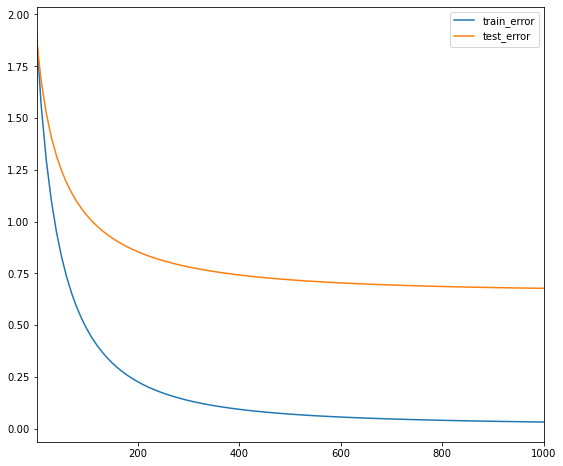

In [112]:
model = build_model(xyz,  embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

I tried to build my model but the high values for listens was giving me errors like so "InvalidArgumentError: indices[4073] = 2077 is not in [0, 1892)". 

This was why I changed the artist and user ID's to 1.) start from zero and 2.) increment by 1 until the length of unique values - 1. I had to normalise my weights then as I kept returning nan values for train and test errors above.

# Inspect Embeddings

In [113]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [114]:
from IPython import display
def artist_neighbors(model, title_substring, measure=DOT, k=6):
  ids =  df[df['name'].str.contains(title_substring)].index.values
  titles = df.iloc[ids]['name'].values
  if len(titles) == 0:
    raise ValueError("Found no artist with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching artist. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  artistID = ids[0]
  scores = compute_scores(
      model.embeddings["artID"][artistID], model.embeddings["artID"],
      measure)
  score_key = measure + ' score'
  df7 = pd.DataFrame({
      score_key: list(scores),
      'names': df['name'],
  })
  display.display(df7.sort_values([score_key], ascending=False).head(k))

##### Similarity Scores for our model
Let's test our model on some well known artists and see what recommendations it returns. The two similarity measures will be the dot product and cosine similarity. Higher values of both are better. To start with the cosine similarity can be defined as the cosine of the angle between two n-dimensional vectors in an n-dimensional space. The cosine similarity formula corresponds as:

$$similarity(A, B) =  {A \cdot B \over |A| \times |B|}$$

Values range between -1 and 1, where -1 is perfectly dissimilar and 1 is perfectly similar. The dot product can be defined in a couple of different ways. It is seen in the cosine similarity formula. The dot product is defined as is equal to the product of the magnitude of the two vectors and the cosecant of the angle between the two [vectors](https://www.cuemath.com/algebra/dot-product/#:~:text=The%20dot%20product%20of%20two%20vectors%20is%20equal%20to%20the,vectors%20follows%20the%20commutative%20property.). One way it is notated is as:

$$ A \cdot B = |A| |B| \times \cosθ $$

It can also be denoted in this format:

$$ A \cdot B =  \sum_{i=1}^n a_i b_i$$

Where:
a	=	1st vector, b	=	2nd vector, n	=	dimension of the vector space, a_i	=	component of vector a, b_i	=	component of vector b



In [115]:
artist_grp = ['Lady Gaga', 'The Killers', 'Black Eyed Peas', 'Rihanna', 'Gwen Stefani', 'AC/DC']
for art in range(len(artist_grp)):
    artist_neighbors(model, artist_grp[art], DOT)
    artist_neighbors(model, artist_grp[art], COSINE)

Nearest neighbors of : Lady Gaga.
[Found more than one matching artist. Other candidates: Lady Gaga VS Christina Aguilera, BeyoncÃ© e Lady Gaga, Lady Gaga feat BeyoncÃ©]


,dot score,names
16356,0.925098,Shawnna
13511,0.874200,BR5-49
16109,0.864573,Ian Ion
14448,0.848581,John Cale
13800,0.827204,Lyrics Born
9982,0.812858,KÄ±raÃ§


Nearest neighbors of : Lady Gaga.
[Found more than one matching artist. Other candidates: Lady Gaga VS Christina Aguilera, BeyoncÃ© e Lady Gaga, Lady Gaga feat BeyoncÃ©]


,cosine score,names
83,1.000000,Lady Gaga
286,0.744032,Christina Aguilera
282,0.684765,Rihanna
460,0.663896,Ke$ha
16356,0.651747,Shawnna
61,0.648179,Madonna


Nearest neighbors of : The Killers.
[Found more than one matching artist. Other candidates: Arctic Monkeys vs The Killers]


,dot score,names
10792,0.669424,Renan Luce
11868,0.667024,"Bono, Glen Hansard & Damien Rice"
8294,0.640611,Marco Borsato
16342,0.628483,Bruce Dickinson & Montserrat Cabelle
16785,0.624216,TeddyLoid
1181,0.615290,We Are The Ocean


Nearest neighbors of : The Killers.
[Found more than one matching artist. Other candidates: Arctic Monkeys vs The Killers]


,cosine score,names
223,1.000000,The Killers
8294,0.608293,Marco Borsato
841,0.602849,Haste the Day
9619,0.593279,Republica
9821,0.584922,Dies Irae
294,0.583627,Katy Perry


Nearest neighbors of : Black Eyed Peas.
[Found more than one matching artist. Other candidates: The Black Eyed Peas, Juanes feat.Black Eyed Peas]


,dot score,names
10823,0.345699,The Burglars
16675,0.328751,Sing-Sing
7679,0.326258,Paul Potts
9971,0.322561,è©©æœˆã‚«ã‚ªãƒª
1954,0.320764,Prefuse 73
8310,0.320724,Voces en el Plasma


Nearest neighbors of : Black Eyed Peas.
[Found more than one matching artist. Other candidates: The Black Eyed Peas, Juanes feat.Black Eyed Peas]


,cosine score,names
300,1.000000,Black Eyed Peas
296,0.693031,P!nk
343,0.637236,The Pussycat Dolls
282,0.626463,Rihanna
7995,0.619446,Queen Latifah
15626,0.617672,Silver Apples


Nearest neighbors of : Rihanna.
[Found more than one matching artist. Other candidates: Rihanna (feat. Drake), Jay-Z, Bono, The Edge & Rihanna, RihannaÌ€, Sean Paul ft. Rihanna, Rihanna-remixado REnan, \Eminem f_ Rihanna]


,dot score,names
13925,0.663406,Radionave
17209,0.643368,Dan Griober
4323,0.643271,A Band Featuring Instruments
8310,0.615734,Voces en el Plasma
4399,0.614190,The Bangles
5408,0.606505,Nadine


Nearest neighbors of : Rihanna.
[Found more than one matching artist. Other candidates: Rihanna (feat. Drake), Jay-Z, Bono, The Edge & Rihanna, RihannaÌ€, Sean Paul ft. Rihanna, Rihanna-remixado REnan, \Eminem f_ Rihanna]


,cosine score,names
282,1.000000,Rihanna
460,0.703720,Ke$ha
83,0.684765,Lady Gaga
283,0.666515,Britney Spears
61,0.660117,Madonna
285,0.635870,Kelly Clarkson


Nearest neighbors of : Gwen Stefani.
[Found more than one matching artist. Other candidates: Panic! at the Disco feat. Britney Spears and Gwen Stefani]


,dot score,names
14920,0.509735,Siavash Ghomayshi
10058,0.494921,Johnny Pearson
13030,0.486891,Hollywood Nobody
1085,0.455970,Kent
9893,0.438431,Dino
8371,0.434909,Randy & The Rainbows


Nearest neighbors of : Gwen Stefani.
[Found more than one matching artist. Other candidates: Panic! at the Disco feat. Britney Spears and Gwen Stefani]


,cosine score,names
519,1.000000,Gwen Stefani
2313,0.615980,HÃ¼meyra
936,0.603509,Journey
10058,0.587979,Johnny Pearson
7263,0.579636,Corrosion of Conformity
14920,0.573819,Siavash Ghomayshi


Nearest neighbors of : AC/DC.


,dot score,names
11740,1.436519,Lunachicks
10263,1.341249,Knxwledge
12793,1.250240,Sibel Can
2981,1.245365,The Carter Family
7567,1.236822,Semisonic
550,1.193626,The Strollers


Nearest neighbors of : AC/DC.


,cosine score,names
700,1.000000,AC/DC
1403,0.644673,Led Zeppelin
11740,0.635786,Lunachicks
1906,0.623724,ë™ë°©ì‹ ê¸°
550,0.621190,The Strollers
6018,0.606945,John Stoneham


While our cosine score results provide very strong recommendations using the dot product model here produces mediocre results at best. This also factors in that the dot product is a very popular method for recommender systems and as a result we will need to incorporate further methods to get better results. We will attempt to use a regularized matrix. The key point of this being that regularization is to enforce conditions, for example sparsity or smoothness, that can produce stable predictive functions and in our case improve our model. Overall, I would have to say this model could definitely be improved upon. Let's try an adaptation of our approach.

# Regularized Matrix

We are going to incorporate a regularized matrix into our model. A regularized matrix is utilised to enforce conditions, for example sparsity or smoothness, that can produce stable predictive [functions](https://en.wikipedia.org/wiki/Matrix_regularization). 

In [116]:
def gravity(U, V):
  return 1. / (U.shape[0].value * V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a = True) * tf.matmul(V, V, transpose_a = True))

def build_regularized_model(data, embedding_dim = 3, regularization_coeff = .1, gravity_coeff = 1., init_stddev = 0.1):
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(xyz)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev = init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev = init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U * U) / U.shape[0].value + tf.reduce_sum(V * V) / V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"userID": U, "artID": V}

  return CFModel(embeddings, total_loss, [losses, loss_components]), U, V

 iteration 2000: train_error_observed=0.032361, test_error_observed=0.050478, observed_loss=0.032361, regularization_loss=0.017247, gravity_loss=0.000685

[{'train_error_observed': 0.032360815, 'test_error_observed': 0.05047809},
 {'observed_loss': 0.032360815,
  'regularization_loss': 0.01724688,
  'gravity_loss': 0.0006848034}]

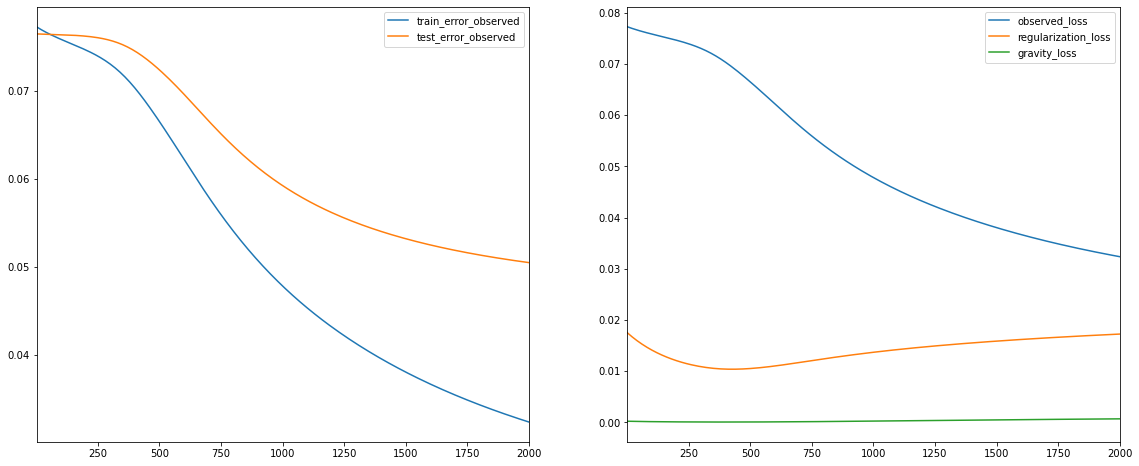

In [117]:
reg_model, u, v  = build_regularized_model(xyz, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35, init_stddev=.05)
reg_model.train(num_iterations=2000, learning_rate=20.)

Let's test our model on the same group of artists from before to get a better understanding of it's recommendations. We will see if these are more valid recommendations than before.

In [118]:
for art in range(len(artist_grp)):
    artist_neighbors(reg_model, artist_grp[art], DOT)
    artist_neighbors(reg_model, artist_grp[art], COSINE)

Nearest neighbors of : Lady Gaga.
[Found more than one matching artist. Other candidates: Lady Gaga VS Christina Aguilera, BeyoncÃ© e Lady Gaga, Lady Gaga feat BeyoncÃ©]


,dot score,names
83,11.956351,Lady Gaga
283,3.328831,Britney Spears
282,3.153648,Rihanna
294,2.786813,Katy Perry
286,2.348049,Christina Aguilera
251,2.305609,Mariah Carey


Nearest neighbors of : Lady Gaga.
[Found more than one matching artist. Other candidates: Lady Gaga VS Christina Aguilera, BeyoncÃ© e Lady Gaga, Lady Gaga feat BeyoncÃ©]


,cosine score,names
83,1.000000,Lady Gaga
640,0.672767,RBD
277,0.652832,Ana Carolina
453,0.633385,*NSYNC
3454,0.618443,Agnes
322,0.614605,David Guetta


Nearest neighbors of : The Killers.
[Found more than one matching artist. Other candidates: Arctic Monkeys vs The Killers]


,dot score,names
223,2.048458,The Killers
201,1.653045,Arctic Monkeys
221,1.651406,The Beatles
184,1.543325,Muse
176,1.438013,Keane
527,1.432857,Oasis


Nearest neighbors of : The Killers.
[Found more than one matching artist. Other candidates: Arctic Monkeys vs The Killers]


,cosine score,names
223,1.000000,The Killers
2594,0.816148,Razorlight
176,0.807922,Keane
2357,0.800195,Backyard Babies
714,0.796813,Social Distortion
447,0.794060,Silverchair


Nearest neighbors of : Black Eyed Peas.
[Found more than one matching artist. Other candidates: The Black Eyed Peas, Juanes feat.Black Eyed Peas]


,dot score,names
282,1.478637,Rihanna
283,1.376997,Britney Spears
492,1.176239,Paramore
289,1.093039,BeyoncÃ©
455,0.981739,Miley Cyrus
83,0.976881,Lady Gaga


Nearest neighbors of : Black Eyed Peas.
[Found more than one matching artist. Other candidates: The Black Eyed Peas, Juanes feat.Black Eyed Peas]


,cosine score,names
300,1.000000,Black Eyed Peas
324,0.817529,T.I.
273,0.806191,Brandy
326,0.799197,Kelly Rowland
235,0.776783,Toni Braxton
4472,0.775504,Amerie


Nearest neighbors of : Rihanna.
[Found more than one matching artist. Other candidates: Rihanna (feat. Drake), Jay-Z, Bono, The Edge & Rihanna, RihannaÌ€, Sean Paul ft. Rihanna, Rihanna-remixado REnan, \Eminem f_ Rihanna]


,dot score,names
282,5.421268,Rihanna
83,3.153648,Lady Gaga
289,2.414663,BeyoncÃ©
283,2.390840,Britney Spears
251,2.156758,Mariah Carey
286,2.048543,Christina Aguilera


Nearest neighbors of : Rihanna.
[Found more than one matching artist. Other candidates: Rihanna (feat. Drake), Jay-Z, Bono, The Edge & Rihanna, RihannaÌ€, Sean Paul ft. Rihanna, Rihanna-remixado REnan, \Eminem f_ Rihanna]


,cosine score,names
282,1.000000,Rihanna
245,0.718536,Whitney Houston
300,0.702294,Black Eyed Peas
539,0.673360,Flo Rida
4701,0.668658,Cody Simpson
308,0.657774,Ciara


Nearest neighbors of : Gwen Stefani.
[Found more than one matching artist. Other candidates: Panic! at the Disco feat. Britney Spears and Gwen Stefani]


,dot score,names
283,1.048183,Britney Spears
83,0.869819,Lady Gaga
286,0.801397,Christina Aguilera
61,0.795499,Madonna
282,0.791222,Rihanna
673,0.670139,Glee Cast


Nearest neighbors of : Gwen Stefani.
[Found more than one matching artist. Other candidates: Panic! at the Disco feat. Britney Spears and Gwen Stefani]


,cosine score,names
519,1.000000,Gwen Stefani
323,0.845820,Justin Timberlake
259,0.821362,CÃ©line Dion
284,0.816289,Jordin Sparks
304,0.795653,Nelly Furtado
296,0.794230,P!nk


Nearest neighbors of : AC/DC.


,dot score,names
1403,1.574423,Led Zeppelin
700,1.549536,AC/DC
157,1.517109,Pink Floyd
908,1.442897,Iron Maiden
701,1.309008,Metallica
227,1.162440,Nine Inch Nails


Nearest neighbors of : AC/DC.


,cosine score,names
700,1.000000,AC/DC
2331,0.858586,Aerosmith
2328,0.778910,KISS
726,0.770634,Alice Cooper
1794,0.766881,MÃ¶tley CrÃ¼e
943,0.758303,Skid Row


These are actually very good recommendations produced by our recommender system based off each users unique normalised values based on the highest listened value they obtained. Our regularized model is much superior on initial inspection than our standard model with much better recommendations all around. Our test error has also decreased noticeably here. Let's test this further on one of the artists here: AC/DC, who would be popular but as should earlier not in the top 20. Let's try verify our results with the appropriate tag information. 

In [119]:
played[played['name'] == 'AC/DC'].head(1)

,name,url,artID,userID,artistID,played,playedUserNorm,playCountScaled
33561,AC/DC,http://www.last.fm/music/AC%252FDC,700,16,700,853,0.390032,0.002416


In [251]:
# id = 700
ac_dc = tags[tags['artistID'] == 700]

Let's just check one of our recommendations for AC/DC as an example. Let's compare the tags left on both these artists by users.

In [253]:
ac_dc_tags = ac_dc['tagValue'].unique()

In [255]:
recs = ['Led Zeppelin', 'Pink Floyd', 'Iron Maiden', 'Metallica', 'Nine Inch Nails',
       'AeroSmith', 'KISS', 'Alice Cooper', 'MÃ¶tley CrÃ¼e', 'Skid Row']

In [285]:
y = df[df['name'].isin(recs)]
rec_id = y['artID'].unique()

In [287]:
zzzz2 = pd.merge(y, tags, how="inner", left_on=['artID'], right_on=['artistID'])

In [288]:
zzzz2

,name,url,pictureURL,artID,tagID,tagValue,userID,artistID
0,Pink Floyd,http://www.last.fm/music/Pink+Floyd,http://userserve-ak.last.fm/serve/252/39219129...,157,14,ambient,1655,157
1,Pink Floyd,http://www.last.fm/music/Pink+Floyd,http://userserve-ak.last.fm/serve/252/39219129...,157,18,electronic,1655,157
2,Pink Floyd,http://www.last.fm/music/Pink+Floyd,http://userserve-ak.last.fm/serve/252/39219129...,157,25,80s,296,157
3,Pink Floyd,http://www.last.fm/music/Pink+Floyd,http://userserve-ak.last.fm/serve/252/39219129...,157,25,80s,513,157
4,Pink Floyd,http://www.last.fm/music/Pink+Floyd,http://userserve-ak.last.fm/serve/252/39219129...,157,25,80s,561,157
...,...,...,...,...,...,...,...,...
2021,KISS,http://www.last.fm/music/KISS,http://userserve-ak.last.fm/serve/252/45524723...,2328,9973,seen in concert,1431,2328
2022,KISS,http://www.last.fm/music/KISS,http://userserve-ak.last.fm/serve/252/45524723...,2328,9997,ae,1438,2328
2023,KISS,http://www.last.fm/music/KISS,http://userserve-ak.last.fm/serve/252/45524723...,2328,10231,old time rock n roll,1479,2328
2024,KISS,http://www.last.fm/music/KISS,http://userserve-ak.last.fm/serve/252/45524723...,2328,12021,weekly top tracks,1776,2328


In [289]:
ac_dc = {}
ac_valz = np.array(zzzz2['tagValue'])
ac_vals = np.array(zzzz2['name'])
for i in range(len(ac_valz)):
    if ac_vals[i] not in d:
        ac_dc[ac_vals[i]] = ""
    else:
        continue
print(ac_dc)

{'Pink Floyd': '', 'Nine Inch Nails': '', 'Metallica': '', 'Alice Cooper': '', 'Iron Maiden': '', 'Skid Row': '', 'Led Zeppelin': '', 'MÃ¶tley CrÃ¼e': '', 'KISS': ''}


In [290]:
for i in range(len(ac_valz)):
    if ac_vals[i] in ac_dc and ac_valz[i] in ac_dc_tags:
        if ac_valz[i] not in ac_dc[ac_vals[i]]:
            ac_dc[ac_vals[i]] += ac_valz[i] + ","
    else:
        continue

In [291]:
def strip_dict(d):
    return dict((k.strip(), v.strip()) for k, v in d.items())

In [292]:
strip_dict(ac_dc)

{'Pink Floyd': '80s,hard rock,alternative,classic rock,epic,90s,70s,guitar,rock n roll,heavy,colors,',
 'Nine Inch Nails': 'metal,80s,rock,alternative,seen live,epic,sexy,90s,cool,heavy,fave,',
 'Metallica': 'metal,80s,hard rock,alternative,seen live,classic rock,epic,90s,heavy metal,cool,arena rock,1008,uhull,famous,',
 'Alice Cooper': 'metal,80s,hard rock,rock and roll,seen live,classic rock,90s,heavy metal,70s,rock n roll,watched live,',
 'Iron Maiden': 'metal,80s,hard rock,seen live,classic rock,epic,sexy,90s,heavy metal,cool,tags,1008,',
 'Skid Row': 'metal,80s,hard rock,classic rock,90s,heavy metal,rock n roll,anos 80,',
 'Led Zeppelin': 'hard rock,alternative,rock and roll,classic rock,epic,heavy metal,blues rock,70s,guitar,rock n roll,guitar solo,arena rock,tags,',
 'MÃ¶tley CrÃ¼e': 'metal,80s,hard rock,seen live,classic rock,90s,heavy metal,great,guitar,rock n roll,cool,tags,watched live,80s rock,',
 'KISS': '80s,hard rock,rock and roll,seen live,classic rock,epic,90s,heavy me

In [293]:
def split_dict(d):
    for key, value in d.items():
        d[key] = value.split(",")

In [294]:
split_dict(ac_dc)

In [296]:
def pop_dict(d):
    for k, v in d.items():
        v.pop()

In [297]:
pop_dict(ac_dc)

In [313]:
def prec_k(d, k):    
    l1 = list(d.items())
    #print(l1)
    count = 0
    for i in range(len(l1)):
        if len(l1[i][1]) > 0:
            count += 1
        else:
            continue
    print("Precision at k equal " + str(k) + " for user/artist with tags information is: " + str(count / k))

In [316]:
prec_k(ac_dc, 9)

Precision at k equal 9 for user/artist with tags information is: 1.0


Taking AC/DC as an example, the tags appear to be incredibly accurate. I wanted to test this to understand how our recommender works and also because I was not sure on some of the artists. At least one tag matches from each artist, there is some spam tags but most are fairly reasonable. We take one off our precision at k value here as AC/DC was already mentioned. This shows how good our recommendations actually were using this regularized model. It must be said that recommendations such as Metallica make plenty of sense. I did not adjust the tag values to index from 0 to unique values minus one here for tag ID's and this shouldn't affect the tags such as those we see here. The user and artist ID's for all files were reindexed approriately which should align with the tag values at hand. We will now move on and see how another recommender system compares to our models based off the google colab provided. 

# Alternate method - Recommender based on Neural Network

Here we will try to implement another type of recommender system and see does it produce equally as good of results. Our alternate model is based off a neural network to make predictions for users based off listening numbers. As per this article on [Investopedia](https://www.investopedia.com/terms/n/neuralnetwork.asp#:~:text=A%20neural%20network%20is%20a,way%20the%20human%20brain%20operates.&text=Neural%20networks%20can%20adapt%20to,to%20redesign%20the%20output%20criteria.) , a neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. Neural networks can adapt to changing input; so the network generates the best possible result without needing to redesign the output criteria. This will help us uncover any listening patterns found in our data by users.

In [121]:
sub = played[['userID', 'artID', 'playedUserNorm']]

In [122]:
sub.head()

,userID,artID,playedUserNorm
0,31,0,0.055775
1,256,0,0.065394
2,729,0,0.025149
3,130,1,0.150902
4,240,1,0.154315


In [123]:
train, test = train_test_split(sub, test_size=0.3, train_size=0.7)

In [124]:
n_users = len(sub.userID.unique())
n_users

1892

In [125]:
n_artist = len(sub.artID.unique())
n_artist

17632

In [126]:
# creating artist embedding path
artist_input = Input(shape=[1], name="Artist-Input")
artist_embedding = Embedding(n_artist + 1, 5, name="Artist-Embedding")(artist_input)
artist_vec = Flatten(name="Flatten-Artist")(artist_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users + 1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# performing dot product and creating model
prod = Dot(name="Dot-Product", axes=1)([artist_vec, user_vec])
model = Model([user_input, artist_input], prod)
model.compile('adam', 'mean_squared_error')

In [127]:
from keras.models import load_model

if os.path.exists('regression_model.h5'):
    model = load_model('regression_model.h5')
else:
    history = model.fit([train.userID, train.artID], train.playedUserNorm, epochs=5, verbose=1)
    model.save('regression_model.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [128]:
model.evaluate([test.userID, test.artID], test.playedUserNorm)

11.709915019610571

In [129]:
predictions = model.predict([test.userID.head(10), test.artID.head(10)])

[print(predictions[i], test.playedUserNorm.iloc[i]) for i in range(0,10)]

[0.9539401] 0.1022525192649674
[0.5931071] 0.0883248730964467
[0.7332239] 0.17059708981435023
[0.05492728] 0.058169375534645
[3.64498] 0.03801526717557252
[3.138496] 0.08087476789766866
[5.732494] 0.022805167413656735
[3.8372645] 0.03981264637002342
[12.145642] 0.09480626545754328
[0.47016686] 0.14745762711864407


[None, None, None, None, None, None, None, None, None, None]

# Neural Network

In [130]:
# creating book embedding path
artist_input = Input(shape=[1], name="Artist-Input")
artist_embedding = Embedding(n_artist + 1, 5, name="Artist-Embedding")(artist_input)
artist_vec = Flatten(name="Flatten-Artists")(artist_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users + 1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([artist_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

# Create model and compile it
model2 = Model([user_input, artist_input], out)
model2.compile('adam', 'mean_squared_error')

In [131]:
from keras.models import load_model

if os.path.exists('regression_model2.h5'):
    model2 = load_model('regression_model2.h5')
else:
    history = model2.fit([train.userID, train.artID], train.playedUserNorm, epochs=5, verbose=1)
    model2.save('regression_model2.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [132]:
model2.evaluate([test.userID, test.artID], test.playedUserNorm)

1868465.5019972352

In [133]:
predictions = model2.predict([test.userID.head(10), test.artID.head(10)])

[print(predictions[i], test.playedUserNorm.iloc[i]) for i in range(0,10)]

[556.89874] 0.1022525192649674
[229.64117] 0.0883248730964467
[1205.8281] 0.17059708981435023
[733.99036] 0.058169375534645
[266.15637] 0.03801526717557252
[308.364] 0.08087476789766866
[2165.578] 0.022805167413656735
[265.78317] 0.03981264637002342
[270.8289] 0.09480626545754328
[234.89717] 0.14745762711864407


[None, None, None, None, None, None, None, None, None, None]

# Visualizing Embeddings

Next, we will visualize our artist embeddings. As per this article [here](https://towardsdatascience.com/recommender-systems-from-learned-embeddings-f1d12288f278), embeddings can be defined as "vector representations of an entity. Each item in the vector represents a feature or a combination of features for that entity".

In [134]:
# Extract embeddings
artist_em = model.get_layer("Artist-Embedding")
artist_em_weights = artist_em.get_weights()[0]

In [135]:
artist_em_weights[:5]

array([[ 0.04103883, -0.2710777 ,  0.28193265,  0.01121594, -0.21962109],
       [ 0.42227656, -0.44878516,  0.46648487, -0.12221594, -0.40105212],
       [-0.18079431, -0.13342255,  0.1553544 , -0.3333101 , -0.00778394],
       [ 0.150518  , -0.19249448,  0.1592992 ,  0.12258738, -0.12723902],
       [ 0.2513393 , -0.21272472,  0.1814355 , -0.22018886, -0.13649407]],
      dtype=float32)

##### PCA
Let's perform principal component analysis (PCA) on our artist embedddings. PCA is defined as the process of computing the principal components and using them to perform a change of basis on the data, sometimes using only the first few principal components and ignoring the rest. It is commonly used in exploratory data [analysis](https://en.wikipedia.org/wiki/Principal_component_analysis). 

<AxesSubplot:>

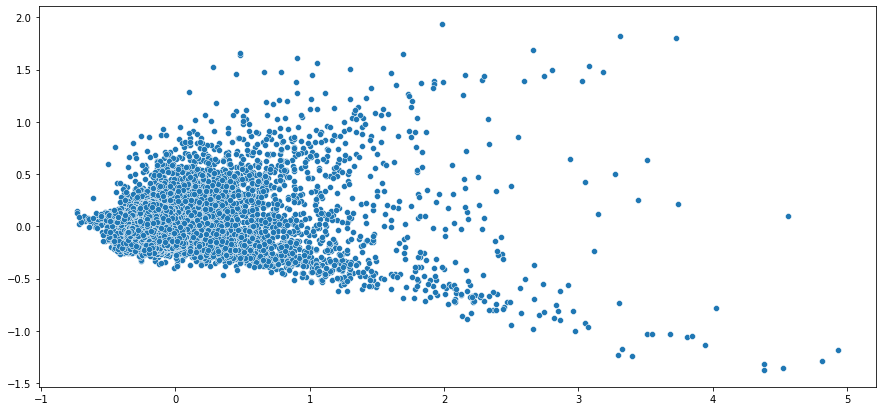

In [136]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(artist_em_weights)
plt.figure(figsize=[15,7])
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [137]:
artist_em_weights = artist_em_weights / np.linalg.norm(artist_em_weights, axis = 1).reshape((-1, 1))
artist_em_weights[0][:10]
np.sum(np.square(artist_em_weights[0]))

1.0

<AxesSubplot:>

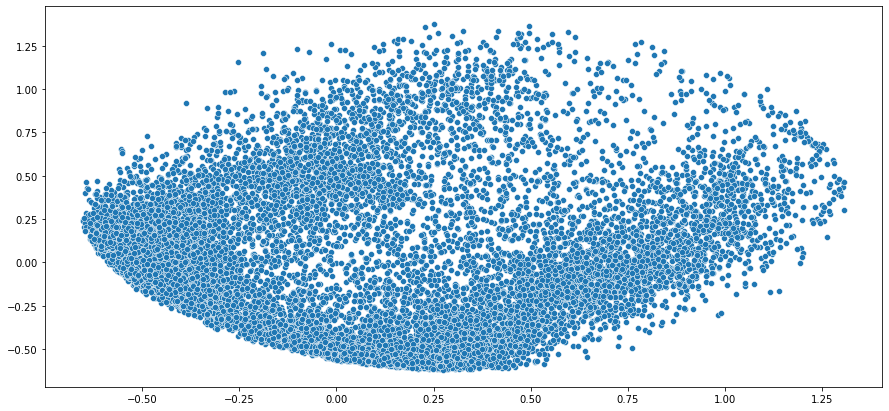

In [138]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(artist_em_weights)
plt.figure(figsize=[15,7])
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

##### TSNE
Let's now look at the t-Distributed Stochastic Neighbor Embeddings (TSNE) for artists. This allows us to see how the artist embeddings are arranged in a high-dimensional space. 

In [139]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(artist_em_weights)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 17633 samples in 0.068s...
[t-SNE] Computed neighbors for 17633 samples in 1.557s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17633
[t-SNE] Computed conditional probabilities for sample 2000 / 17633
[t-SNE] Computed conditional probabilities for sample 3000 / 17633
[t-SNE] Computed conditional probabilities for sample 4000 / 17633
[t-SNE] Computed conditional probabilities for sample 5000 / 17633
[t-SNE] Computed conditional probabilities for sample 6000 / 17633
[t-SNE] Computed conditional probabilities for sample 7000 / 17633
[t-SNE] Computed conditional probabilities for sample 8000 / 17633
[t-SNE] Computed conditional probabilities for sample 9000 / 17633
[t-SNE] Computed conditional probabilities for sample 10000 / 17633
[t-SNE] Computed conditional probabilities for sample 11000 / 17633
[t-SNE] Computed conditional probabilities for sample 12000 / 17633
[t-SNE] Computed conditional probabilities for sa

<AxesSubplot:>

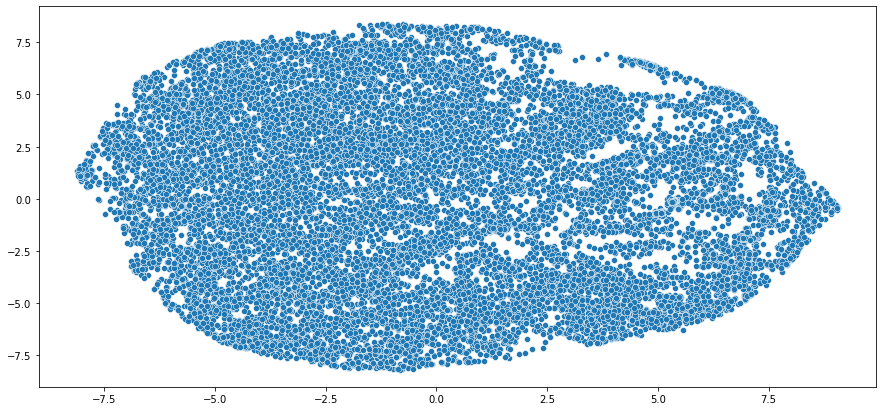

In [140]:
plt.figure(figsize=[15,7])
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

There are no clusters here that jump out at me here to delve into further. They are all of a similar distribution and no cluster appears massively obvious.

# Making Recommendations

In [176]:
# Creating dataset for making recommendations for a user
artist_data = np.array(list(set(sub.artID)))
artist_data

array([    0,     1,     2, ..., 17629, 17630, 17631])

Let's pick a random user to generate recommendations for. We will go with the user of ID equalling 10.

In [177]:
user = np.array([10 for i in range(len(artist_data))])
user

array([10, 10, 10, ..., 10, 10, 10])

In [178]:
predictions = model.predict([user, artist_data])

predictions = np.array([a[0] for a in predictions])

recommended_artist_ids = (predictions).argsort()[:10]

recommended_artist_ids

array([8131, 8135, 8324, 8139, 2754, 8317, 8136, 8151, 8315, 8333],
      dtype=int64)

In [179]:
predictions[recommended_artist_ids]

array([-0.57746166, -0.57243985, -0.53917485, -0.51835954, -0.5130869 ,
       -0.5057626 , -0.5038766 , -0.49716717, -0.47062764, -0.44993132],
      dtype=float32)

In [180]:
df[df['artID'].isin(recommended_artist_ids)]

,name,url,pictureURL,artID
2754,Dark Funeral,http://www.last.fm/music/Dark+Funeral,http://userserve-ak.last.fm/serve/252/13074411...,2754
8131,Nahash,http://www.last.fm/music/Nahash,http://userserve-ak.last.fm/serve/252/93322.jpg,8131
8135,Krabaras,http://www.last.fm/music/Krabaras,http://userserve-ak.last.fm/serve/252/44372179...,8135
8136,DiktatÅ«ra,http://www.last.fm/music/Diktat%C5%ABra,http://userserve-ak.last.fm/serve/252/165489.jpg,8136
8139,Luctus,http://www.last.fm/music/Luctus,http://userserve-ak.last.fm/serve/252/8688989.jpg,8139
8151,Anubi,http://www.last.fm/music/Anubi,http://userserve-ak.last.fm/serve/252/27058983...,8151
8315,Gallhammer,http://www.last.fm/music/Gallhammer,http://userserve-ak.last.fm/serve/252/607745.jpg,8315
8317,Ossastorium,http://www.last.fm/music/Ossastorium,http://userserve-ak.last.fm/serve/252/51798.jpg,8317
8324,Dissimulation,http://www.last.fm/music/Dissimulation,http://userserve-ak.last.fm/serve/252/16340589...,8324
8333,Surdr,http://www.last.fm/music/Surdr,http://userserve-ak.last.fm/serve/252/40530837...,8333


Let's check does our recommender produce novel results. In our recommender system as mentioned earlier it can be hard to gauge good recommenders in a formal manner (not a subjective manner such as a user rating the recommendations) as there is no ratings just listening figures. Users would eventually tire of being suggested the same artists so checking our recommender to see if it produces novel results is a good barometer of it's quality to start.

In [182]:
test = played[played['userID'] == 10]

In [183]:
test[test['artID'].isin(recommended_artist_ids)]

,name,url,artID,userID,artistID,played,playedUserNorm,playCountScaled


Our recommender has produced completely novel results here for the user. This is potentially a good starting point for our recommender. Let's delve further into it's results looking at the recommendations for this particular user.

In [185]:
usert = tags[tags['userID'] == 10]

In [186]:
usert

,tagID,tagValue,userID,artistID
1,1,metal,10,175
2,1,metal,10,192
3,1,metal,10,494
4,1,metal,10,497
5,1,metal,10,506
...,...,...,...,...
92593,197,gangsta rap,10,13742
92669,198,rapcore,10,483
92670,198,rapcore,10,504
92671,198,rapcore,10,1854


In [187]:
m = usert['tagValue'].unique()

In [188]:
tagtest =  pd.merge(usert, test, how="inner", left_on=['userID', 'artistID'], right_on=['userID', 'artistID'])

In [190]:
zzzz = df[df['artID'].isin(recommended_artist_ids)]

In [191]:
zzzz1 = pd.merge(zzzz, tags, how="inner", left_on=['artID'], right_on=['artistID'])

In [203]:
zzzz1

,name,url,pictureURL,artID,tagID,tagValue,userID,artistID
0,Dark Funeral,http://www.last.fm/music/Dark+Funeral,http://userserve-ak.last.fm/serve/252/13074411...,2754,1,metal,404,2754
1,Dark Funeral,http://www.last.fm/music/Dark+Funeral,http://userserve-ak.last.fm/serve/252/13074411...,2754,4,black metal,211,2754
2,Dark Funeral,http://www.last.fm/music/Dark+Funeral,http://userserve-ak.last.fm/serve/252/13074411...,2754,4,black metal,404,2754
3,Dark Funeral,http://www.last.fm/music/Dark+Funeral,http://userserve-ak.last.fm/serve/252/13074411...,2754,4,black metal,658,2754
4,Dark Funeral,http://www.last.fm/music/Dark+Funeral,http://userserve-ak.last.fm/serve/252/13074411...,2754,4,black metal,941,2754
5,Dark Funeral,http://www.last.fm/music/Dark+Funeral,http://userserve-ak.last.fm/serve/252/13074411...,2754,2091,true black metal,404,2754
6,Dark Funeral,http://www.last.fm/music/Dark+Funeral,http://userserve-ak.last.fm/serve/252/13074411...,2754,3343,melodic black metal,404,2754
7,Dark Funeral,http://www.last.fm/music/Dark+Funeral,http://userserve-ak.last.fm/serve/252/13074411...,2754,3509,extreme metal,404,2754
8,Nahash,http://www.last.fm/music/Nahash,http://userserve-ak.last.fm/serve/252/93322.jpg,8131,4,black metal,548,8131
9,Krabaras,http://www.last.fm/music/Krabaras,http://userserve-ak.last.fm/serve/252/44372179...,8135,4366,flar flar flar,548,8135


### Let's Evaluate our alternate system's recommendations
Let's try calculate precision here for values. We will look to see what tags have been assigned by user 10 that has been assigned to the recommended artists our new system has left them. If at least one tag is found in both the user and the recommended artists tags we assign a score of 1 (relevant) to our user. I will use a method of "precision at K". As per [Wikipedia](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Precision_at_k), it is defined as "Precision at k documents (P@k) is still a useful metric (e.g., P@10 or "Precision at 10" corresponds to the number of relevant results among the top 10 retrieved documents), but fails to take into account the positions of the relevant documents among the top k". It is commonly used for evaluating music recommender systems. Out of the first K artists recommended we see how many of these are deemed relevant. As mentioned earlier our relevance can be deemed as an artist who has been given a tag by other users that is also a tag given by the user in question, user 10. I feel this is the most practical method of evaluating this system. Anyone with experience of using Spotify or SoundCloud would see that for recommendations you would only look at the first few maybe and lose interest after that. It is also hoped the first few recommendations are of a higher quality and more likely to attract a user's attention.

In [304]:
d = {}
valz = np.array(zzzz1['tagValue'])
vals = np.array(zzzz1['name'])
for i in range(len(valz)):
    if vals[i] not in d:
        d[vals[i]] = ""
    else:
        continue
print(d)

{'Dark Funeral': '', 'Nahash': '', 'Krabaras': '', 'DiktatÅ«ra': '', 'Gallhammer': ''}


In [305]:
# only these artists from recommended had tags left on them
valz = np.array(zzzz1['tagValue'])
vals = np.array(zzzz1['name'])
for i in range(len(valz)):
    if vals[i] in d and valz[i] in m:
        if valz[i] not in d[vals[i]]:
            d[vals[i]] += valz[i] + ","
    else:
        continue

In [306]:
strip_dict(d)

{'Dark Funeral': 'metal,',
 'Nahash': '',
 'Krabaras': '',
 'DiktatÅ«ra': '',
 'Gallhammer': ''}

In [307]:
split_dict(d)

In [308]:
pop_dict(d)

In [309]:
d

{'Dark Funeral': ['metal'],
 'Nahash': [],
 'Krabaras': [],
 'DiktatÅ«ra': [],
 'Gallhammer': []}

In [315]:
prec_k(d, 10)

Precision at k equal 10 for user/artist with tags information is: 0.1


Looking at the results at face value the recommendations actually seem quite good for this user. A lot of these recommended artists have metal related types of tags, something that definitely seemed to resonate with this user. The only real reason are precision at k value is not higher here is because of values such as "industrial mental" and "doom mental", while some of he tags related to the recommendations are the likes of "black metal" and "extreme metal", much more personalized tags instead of a mainstream tag such as "mental". One thing I found was that the removal of users with ID's not part of the wider dataset that some of these tags appeared relevant to mental and some of these recommendations. This definitely is why not all 10 recommended artists appeared here and why the precision at k was slightly lower. However, this probably does highlight the limitations of such an approach as strings need to perfectly align but I felt it was the most appropriate approach for testing user based recommendations and not artist based recommendations like before.

# Spotify Recommender system with regularized model

Here I will attempt to test my recommender system on my own personal spotify account to see what recommendations it provides. While it must be noted my music taste is not exactly mainstream for the most part, this should be a good test of the sturdiness of the recommender system. We will be using our first recommender system based on user and artist ID and each users uniquely normalised listening column. We will do this using the Tekore python library. This is the most popular spotify api library alongside "spotipy" but I felt tekore was more appropriate for the work at hand here. 

In [163]:
import tekore as tk

In [207]:
# covering these details
client_id = '#'
client_secret = '#'

In [208]:
# always use this link
redirect_url = 'https://example.com/callback'

In [209]:
conf = (client_id, client_secret, redirect_url)
token = tk.prompt_for_user_token(*conf, scope = tk.scope.every)

spotify = tk.Spotify(token)

# paste in link from new webpage opened up by this spotify call above into cell below

Opening browser for Spotify login...
Please paste redirect URL: https://example.com/callback?code=AQAsHCBINxWnnPm38B_u8r4qOMf4VTCl7CzMTIlw9HIRaWam5E9rESKEx9jnGe0nICHdmdiMgFxsYdW8s1vH3Zw-NMb4w9gNm5L6QtuTaveZYfdkA1ZuDfhdQUsUHP2feIWOq4VyJwSfMqe_oqkmT2mYeQ1S0f51LrS8JUUQprF-l_PeptEOBXpRZTm5O4HRZDTyhxpnHBNViMCazPVjaYxiN6aY99f2hqBT2CLPsKmTkgw9bjGkHLfkqWImhDltJpfpYNgDbd8Zmyg8oi2sBwBaqV3SZR6kTFJtbz9jOjxPDba3qSZaYj_1RSC3Ntb3I_gGVIBwGLeCwTSVLItiUjAMcLgApS16zYmqFTnhQrKKtsFaAM4COR7JbKHMaeQ7Oby3n1PprhTRCkhigvACujhCD0LaUMbqPBfri54Y1LMLnOx00HEOjcQzG4MDM3RVN7kh14VmRTnaJ3tFuE1MB5GK486-AA3CBJ6AIEdYErupIIBST-y_AgZx1zx_3S6bNtn54aMuwrte_fxqxEX-jfNuqGGhVafG7kWwNZr-pg1qr-l2gfB8_c3otrxNJHzWIxeqGyj6KpkO2VnQElnfhJVShRi5gyEgWBf0WP9jwcqogvmRG3oW4hwqSTmUx-v_ZtX9LjfxXZ4bBJXL_BhQK1-U-fQSfU7pcJAyE4byCBNmJCg&state=AR_0J-L7FvkMek7U9N5iKI2BSpq1KtYw3x7fb6Wj344


In [210]:
artists = spotify.current_user_top_artists(limit = 10)
spotify_artists = artists.items

In [211]:
t = np.array(df['name'])
for i in range(len(spotify_artists)):
    if spotify_artists[i].name in t: 
        artist_neighbors(reg_model, spotify_artists[i].name, DOT)
        artist_neighbors(reg_model, spotify_artists[i].name, COSINE)
    else:
        print(str(spotify_artists[i].name) + " is not in the LastFM data.")

Nearest neighbors of : Calvin Harris.


,dot score,names
148,0.757569,Radiohead
673,0.645099,Glee Cast
167,0.643843,Placebo
283,0.581608,Britney Spears
1089,0.579911,BjÃ¶rk
184,0.563266,Muse


Nearest neighbors of : Calvin Harris.


,cosine score,names
1400,1.000000,Calvin Harris
1081,0.827695,Franz Ferdinand
748,0.823963,Crystal Castles
5424,0.809302,Passion Pit
161,0.799802,Scissor Sisters
1088,0.798873,Patrick Wolf


Mark Blair is not in the LastFM data.
Tobu is not in the LastFM data.
Bissett is not in the LastFM data.
Uniting Nations is not in the LastFM data.
Nearest neighbors of : David Guetta.
[Found more than one matching artist. Other candidates: Chris Willis; David Guetta; Fergie; LMFAO]


,dot score,names
83,1.401576,Lady Gaga
283,1.329221,Britney Spears
61,0.809036,Madonna
282,0.781358,Rihanna
492,0.779988,Paramore
286,0.767425,Christina Aguilera


Nearest neighbors of : David Guetta.
[Found more than one matching artist. Other candidates: Chris Willis; David Guetta; Fergie; LMFAO]


,cosine score,names
322,1.000000,David Guetta
458,0.871919,3OH!3
517,0.862911,Lindsay Lohan
155,0.803901,Enrique Iglesias
1023,0.802028,Jessie J
317,0.800165,The Saturdays


Low Steppa is not in the LastFM data.
Sonny Fodera is not in the LastFM data.
Ewan McVicar is not in the LastFM data.
Pete Heller's Big Love is not in the LastFM data.


#### Personal Opinions on these recommendations
As referenced earlier some of these artists aren't exactly mainstream, massively popular artists to a wider audience, hence the limited number of found artists. Calvin Harris and David Guetta are popular artists and the recommendations made by our recommender are actually good between dot score and cosine scores. On the whole I definitely find these recommendations quite good. These artists recommended are definitely not in my more popular artists and it is a good sign of the recommender system it is showing new artists. The recommendations for David Guetta and Calvin Harris are in my opinion very logical. There are artists that have collaborated with the pair in both sets of recommendations and other artists of a similar ilk who are not in my top artists. It must also be noted this dataset is from 2011 so the recommendations are based off a slightly more limited market of artists too which is why some of these artists could not be found and why some recommendations may be slightly more predictable.

# Evaluation

We will now try to evaluate our results and methods attempted so far. I will look at using methods such as Recall, Precision, Coverage and F1 to validate our methods. I feel methods such as mean absolute error (MAE) and root mean square error (RMSE) are not suitable to our data provided. These look at the difference between the actual and predicted values, which are not really applicable to the data here. The predicted artist could be number 1 and the actual artist could be 2 and this would appear as a very good result using this method. However, the difference in genres and similarity of artist could be completely different and hence the result is misleading. We will look to implement evaluation using the "LightFM" python library.

In [212]:
import implicit
from tqdm import tqdm_notebook as tqdm
import matplotlib.ticker as ticker
from matplotlib import rc
from pandas.api.types import CategoricalDtype
import string
import re
import random
import math
from math import sqrt
from math import log
from collections import Counter, defaultdict
from operator import itemgetter
from pylab import rcParams
from pylab import savefig

In [217]:
# Create sparse matrix from dataframe object
def create_sparse_matrix(data):
  #get unique user ids and unique artist ids
  users = list(np.sort(data.userID.unique()))
  artists = list(data.artistID.unique())
# change data.col below to whatever column's precision etc is to be evaluated
  plays = list(data.playedUserNorm)

  cat_type = CategoricalDtype(categories=users, ordered=True)
  rows = data.userID.astype(cat_type).cat.codes

  cat_type = CategoricalDtype(categories=artists, ordered=True)
  cols = data.artistID.astype(cat_type).cat.codes
  # we get the rows (user ids) and columns (artist ids) and populate them using plays
  plays_sparse = scipy.sparse.csr_matrix((plays, (rows, cols)), shape=(len(users),len(artists)))
  return plays_sparse

In [214]:
# Calculate sparsity of matrix
def calculate_sparsity(M):
  matrix_size = float(M.shape[0] * M.shape[1]) # Number of total possible interactions between artist and user in the matrix
  num_plays = len(M.nonzero()[0]) # Number of times any artist has been interacted with
  sparsity = 100 * (1 - float(num_plays / matrix_size))
  return sparsity

In [215]:
def evaluate_lightfm(model, original, train, test, user_features=None, item_features=None, n_rec = 20):
    print("Evaluating LightFM...")
    print("Calculating Coverage...")
    catalog = []
    for user in tqdm(range(0, original.shape[0])):
      #get scores for this particular user for all artists
      rec_scores = model.predict(user,np.arange(original.shape[1]),user_features=user_features, item_features=item_features)
      #get top k items to recommend
      rec_items = (-rec_scores).argsort()[:20]
      #calculate coverage
      #coverage calculation
      for recs in rec_items:
        if recs not in catalog:
          catalog.append(recs)
            
    coverage = len(catalog)/float(original.shape[1])
    print("Calculating Recall at k...")
    recall = recall_at_k(model, test, user_features = user_features, item_features = item_features, k = n_rec).mean()
    print("Calculating Precision at k...")
    precision = precision_at_k(model, test, user_features = user_features, item_features = item_features, k = n_rec).mean()
    f1 = (2 * precision * recall) / (precision + recall)
    return coverage, precision, recall, f1

In [218]:
playedx = played[['userID','artistID', 'playedUserNorm']]
playedx.columns = ['userID','artistID', 'playedUserNorm']

#create sparse matrix like earlier
plays_sparse_light = create_sparse_matrix(playedx).astype('float')
print('Matrix Sparsity:', calculate_sparsity(plays_sparse_light))

train_ratings, test_ratings = split_dataframe(xyz)
# SparseTensor representation of the train and test datasets.
A_train = build_rating_sparse_tensor(train_ratings)
A_test = build_rating_sparse_tensor(test_ratings)

train_light, test_light = lightfm.cross_validation.random_train_test_split(plays_sparse_light, test_percentage = 0.7)
model_fm_vanilla = LightFM(learning_rate=0.05, loss='bpr')

#train model
print("Fitting model...")
model_fm_vanilla.fit(train_light, epochs=10)

#evaluate model
coverage, precision, recall, f1 = evaluate_lightfm(model_fm_vanilla, plays_sparse_light, train_light, test_light)
print("Precision:", precision * 100, '%')
print("Recall:", recall * 100, '%')
print("Coverage:", coverage * 100, '%')
print("F1:", f1 * 100, '%')

Matrix Sparsity: 99.72171848800758
Fitting model...
Evaluating LightFM...
Calculating Coverage...


C:\Users\user\AppData\Local\Temp/ipykernel_28620/314659252.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user in tqdm(range(0, original.shape[0])):


  0%|          | 0/1892 [00:00<?, ?it/s]

Calculating Recall at k...
Calculating Precision at k...
Precision: 12.798941135406494 %
Recall: 7.443328632047587 %
Coverage: 0.8847549909255897 %
F1: 9.41265244535319 %


In [216]:
playedx = played[['userID','artistID', 'playCountScaled']]
playedx.columns = ['userID','artistID', 'playCountScaled']

#create sparse matrix like earlier just compatible with lightFM
plays_sparse_light = create_sparse_matrix(playedx).astype('float')
print('Matrix Sparsity:', calculate_sparsity(plays_sparse_light))

# split up data like we did earlier with our split_dataframe function
train_light, test_light = lightfm.cross_validation.random_train_test_split(plays_sparse_light, test_percentage = 0.7)
model_fm_vanilla = LightFM(learning_rate=0.05, loss='bpr')

#train model
print("Fitting model...")
model_fm_vanilla.fit(train_light, epochs=10)

#evaluate model
coverage, precision, recall, f1 = evaluate_lightfm(model_fm_vanilla, plays_sparse_light, train_light, test_light)
print("Precision:", precision * 100, '%')
print("Recall:", recall * 100, '%')
print("Coverage:", coverage * 100, '%')
print("F1:", f1 * 100, '%')

Matrix Sparsity: 99.72362497745786
Fitting model...
Evaluating LightFM...
Calculating Coverage...


C:\Users\user\AppData\Local\Temp/ipykernel_28620/314659252.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user in tqdm(range(0, original.shape[0])):


  0%|          | 0/1892 [00:00<?, ?it/s]

Calculating Recall at k...
Calculating Precision at k...
Precision: 13.239957392215729 %
Recall: 7.707198593051993 %
Coverage: 0.7599818511796733 %
F1: 9.742895986177876 %


Our chosen accuracy when normalising with each user's max score is actually worse than our play count scaled metric. However, when I ran this with playCountScaled used for our recommender the recommendations were dreadful with very low dot and cosine scores. Of the sample of artists and my spotify recommendations the recommendations using the playedUserNorm column seemed far more accurate. This is probably because the scores are better scaled between 0 and 1, identifying popular artists more easily with values closer to 1 and also less known artists would have a better chance of being noticed if a handful of users listened to them a lot. However, it could also be said that it may produce more novel recommendations like our alternate approach. By this I mean that while on initial inspection the results seemed poor the recommender actually makes relevant recommendations to the user that they have not seen before.

# Clustering Attempt

Here, I am going to attempt to cluster on the most popular tags. I will take the top 100 tags and cluster accordingly off one of their mean, median, sum of plays or other to see what trends seem to appear in the data. We will be implementing our k-means algorithm used in assignment 1.

In [219]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

In [220]:
m = tags['tagValue'].value_counts()[:100]

In [221]:
df23 = pd.DataFrame(m)

In [222]:
df23 = df23.reset_index()

In [223]:
df23.rename(columns={'index': 'tagValue', 'tagValue': 'count'}, inplace=True)

In [224]:
df23.drop(columns=['count'], inplace=True)

In [225]:
a = np.array(df23['tagValue'])
df24 = tags[tags['tagValue'].isin(a)]

In [226]:
df24.shape

(112379, 4)

In [227]:
df2.head()

,userID,artistID,weight
0,0,45,13883
1,0,46,11690
2,0,47,11351
3,0,48,10300
4,0,49,8983


In [228]:
df25 = pd.merge(df24, df2, how="inner", left_on=["artistID", "userID"], right_on=["artistID", "userID"])

In [229]:
df25['tagValue'].nunique()

100

In [230]:
df25.head()

,tagID,tagValue,userID,artistID,weight
0,1,metal,10,494,2471
1,176,emo,10,494,2471
2,1,metal,10,497,1714
3,5,death metal,10,497,1714
4,1,metal,10,506,1260


In [231]:
grouped_multiple11 = df25.groupby(['tagValue']).agg({'weight': ['mean', 'median', 'max', 'sum']})

In [232]:
grouped_multiple11.head()

weight                        
                 mean median     max      sum
tagValue                                     
00s       3197.503311  626.0  172496   965646
60s       1513.513089  460.0   23792   289081
70s       1090.209559  370.5   22851   296537
80s       1817.259705  430.0  107031  1357493
90s       2682.854651  612.5  172496  1384353

In [233]:
grouped_multiple11 = grouped_multiple11.reset_index()

In [234]:
grouped_multiple11.columns = ['tagValue', 'mean', 'med', 'max', 'sum']

In [235]:
grouped_multiple11.head()

,tagValue,mean,med,max,sum
0,00s,3197.503311,626.0,172496,965646
1,60s,1513.513089,460.0,23792,289081
2,70s,1090.209559,370.5,22851,296537
3,80s,1817.259705,430.0,107031,1357493
4,90s,2682.854651,612.5,172496,1384353


In [236]:
tag_nos = []
for i in range(0, 100):
    tag_nos.append(i)

In [237]:
tag_nos[-1]

99

In [238]:
grouped_multiple11['tagNo'] = tag_nos

In [239]:
grouped_multiple11.head()

,tagValue,mean,med,max,sum,tagNo
0,00s,3197.503311,626.0,172496,965646,0
1,60s,1513.513089,460.0,23792,289081,1
2,70s,1090.209559,370.5,22851,296537,2
3,80s,1817.259705,430.0,107031,1357493,3
4,90s,2682.854651,612.5,172496,1384353,4


In [240]:
b = np.array(grouped_multiple11['tagValue'])
test7 = np.array(df23['tagValue'][:20])
ind = []
for i in range(len(b)):
    if b[i] in test7:
        ind.append(i)
    else:
        continue

In [241]:
ind

[3, 4, 7, 8, 10, 17, 22, 27, 33, 36, 40, 47, 54, 56, 66, 68, 71, 85, 88, 90]

In [242]:
grouped_multiple11.drop(columns=['tagValue'], inplace=True)
scaler = preprocessing.StandardScaler().fit(grouped_multiple11)
X_scaled = scaler.transform(grouped_multiple11)
X_scaled.std(axis=0)

standard_all = pd.DataFrame(X_scaled)

In [243]:
standard_all = standard_all.rename(columns={0:'mean', 1: 'med', 2: 'max', 3: 'sum',
                                           4: 'tagNo'})

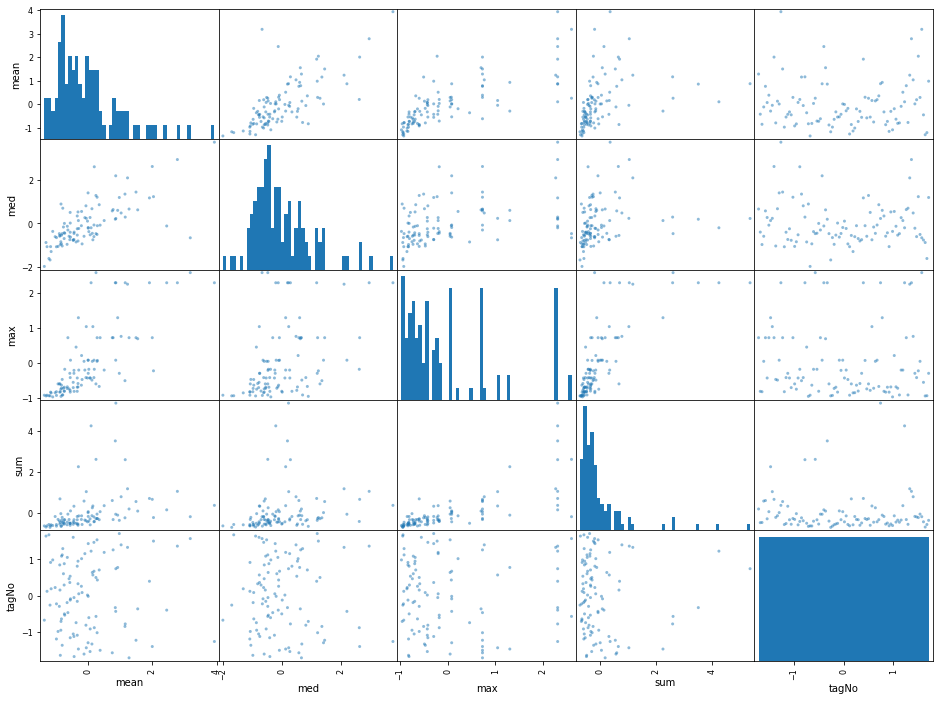

In [244]:
pd.plotting.scatter_matrix(standard_all, figsize=(16,12), hist_kwds=dict(bins=50), cmap="Set1")
plt.show()

In [245]:
for n in range(2, 11):
    km = KMeans(n_clusters=n)
# Fit the KMeans model
    km.fit_predict(standard_all)
# Calculate Silhoutte Score
    score = silhouette_score(standard_all, km.labels_, metric='euclidean')
# Print the score
    print('K = ' + str(n) + ' Silhouette Score: %.3f' % score)

K = 2 Silhouette Score: 0.426
K = 3 Silhouette Score: 0.427
K = 4 Silhouette Score: 0.269
K = 5 Silhouette Score: 0.284
K = 6 Silhouette Score: 0.270
K = 7 Silhouette Score: 0.269
K = 8 Silhouette Score: 0.268
K = 9 Silhouette Score: 0.255
K = 10 Silhouette Score: 0.234


K = 3 is the optimal value it appears for our value of K.

In [246]:
kmeans_margin_standard = KMeans(n_clusters=3).fit(standard_all[["tagNo", "mean"]])
centroids_betas_standard = kmeans_margin_standard.cluster_centers_

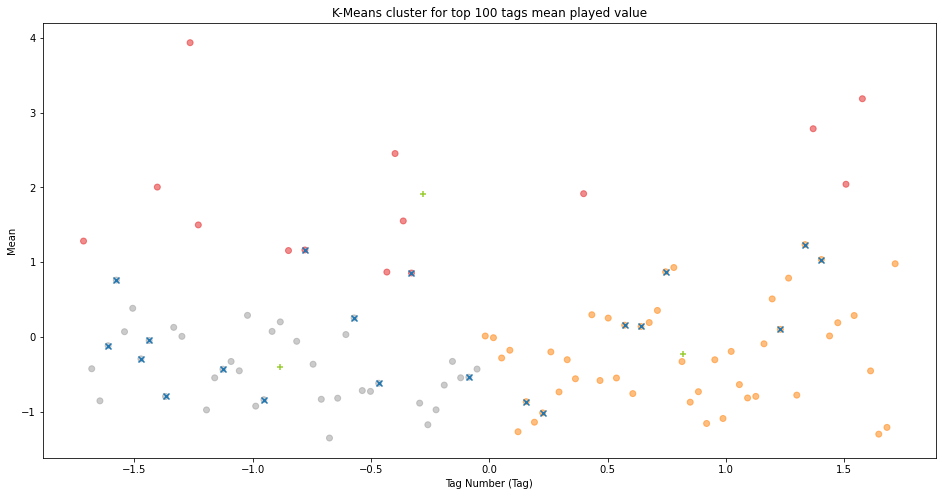

In [247]:
# df44 is top 20 most popular tags, designated by x's on points
df44 = standard_all[standard_all.index.isin(ind)]
plt.figure(figsize=(16,8))
plt.scatter(standard_all['tagNo'], standard_all['mean'], c= kmeans_margin_standard.labels_, cmap = "Set1", alpha=0.5)
plt.scatter(centroids_betas_standard[:, 0], centroids_betas_standard[:, 1], c='yellowgreen', marker='+')
plt.scatter(df44['tagNo'], df44['mean'], marker='x')
plt.title('K-Means cluster for top 100 tags mean played value')
plt.xlabel('Tag Number (Tag)')
plt.ylabel('Mean')
plt.show()

When we cluster on tag numbers (tag values essentially) against the mean played value for the tag, it is interesting to note that the top 20 most popular tags have roughly only an average mean value, which is the clusters denoted by grey and orange here. This was despite tags such as "rock" which had by a distance the most value counts of either tag being seemingly more popular than the less popular of our 100 collected tags. Comparing the three clusters we have here the cluster with the highest values of the mean contains only two tags from our top 20 tags. This is certainly interesting to note that the most popular tags don't appear to have the necessarily the highest mean values. The slightly less mainstream tags may attract a smaller audience but our cluster suggests that these users are huge fans of these types of music genres and hence have a higher mean. It also suggests that there could be more spam tags with much smaller "played" values attached to them bringing these tags respective mean values down. Some users might try listen to some of these artists aligned with popular tags and not be huge fans, hence a lower played value and a lower mean average for this tag value.